In [1]:
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm  # Importa tqdm para mostrar la barra de progreso
from pprint import pprint
from bs4 import BeautifulSoup
import re
from time import sleep
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from wordcloud import WordCloud


In [9]:

import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
df_reptiles = pd.read_csv("Reptiles_air.csv")

In [6]:
#Conteo de taxonomy order

df_reptiles["taxonomy_order"].unique()

df_reptiles['taxonomy_order'] = df_reptiles['taxonomy_order'].str.lower()

# Diccionario para ponerles a todos el mismo concepto si compete
grupos_similares = {
    'squamata': 'squamata',
    'squmata': 'squamata',
    'squamat': 'squamata',
    'reptilia order:\tsquamata': 'squamata',
}

# Agrupamos y contabilizamos correctamente
df_reptiles['taxonomy_order'] = df_reptiles['taxonomy_order'].replace(grupos_similares)


conteo = df_reptiles['taxonomy_order'].value_counts()

print(conteo)


squamata        167
testudines       20
crocodilia        7
sphenodontia      1
unknown           1
Name: taxonomy_order, dtype: int64


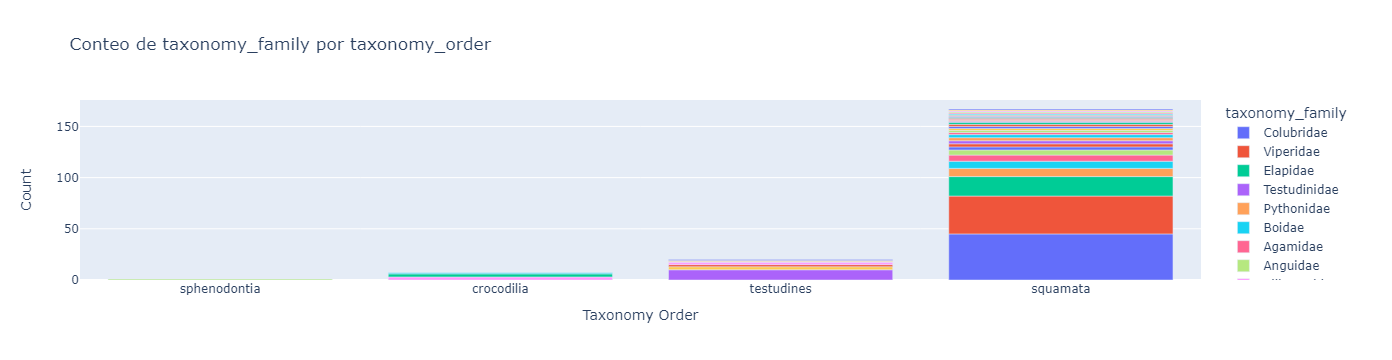

In [10]:
#Agrupacion de taxonmy order

df_reptiles_filtrado = df_reptiles[(df_reptiles['taxonomy_order'] != 'unknown') & (df_reptiles['taxonomy_family'] != 'unknown')]

# Agrupa los datos filtrados por 'taxonomy_order' y 'taxonomy_family' y cuenta el número de ocurrencias
df_agrupado = df_reptiles_filtrado.groupby(['taxonomy_order', 'taxonomy_family']).size().reset_index(name='count')

# Ordena el DataFrame por el conteo ('count') de mayor a menor
df_agrupado = df_agrupado.sort_values(by='count', ascending=False)

# Crea el gráfico de barras apiladas
fig = px.bar(df_agrupado, x='taxonomy_order', y='count', color='taxonomy_family',
             title='Conteo de taxonomy_family por taxonomy_order',
             labels={'count': 'Count'})

# Personalización
fig.update_layout(xaxis_title='Taxonomy Order', yaxis_title='Count')
fig.update_xaxes(categoryorder='total ascending')

# Muestra el gráfico
fig.show()



In [11]:
#Caracteristicas de habitat 
# Palabras de parada
nltk.download('stopwords')

# Función para limpiar y extraer palabras clave
def extract_keywords(description):
    # Tokeniza y convierte en minúscula
    words = nltk.word_tokenize(description.lower())
    
    # Filtra las palabras de parada
    words = [word for word in words if word not in stopwords.words('english')]
    
    # Elimina signos de puntuación
    words = [word for word in words if word.isalnum()]
    
    # Devuelve una palabra clave (la primera palabra) o 'Desconocido' si está vacío
    return words[0] if words else 'Desconocido'

# Aplica la función de extracción de palabras clave a la columna
df_reptiles['characteristics_habitat_clave'] = df_reptiles['characteristics_habitat'].apply(extract_keywords)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


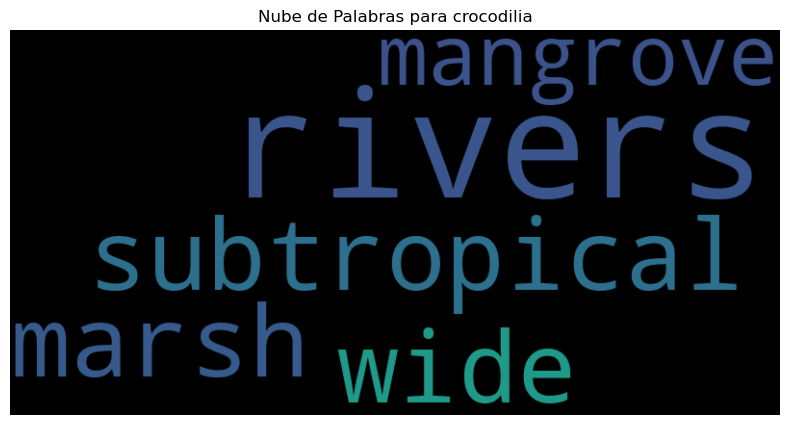

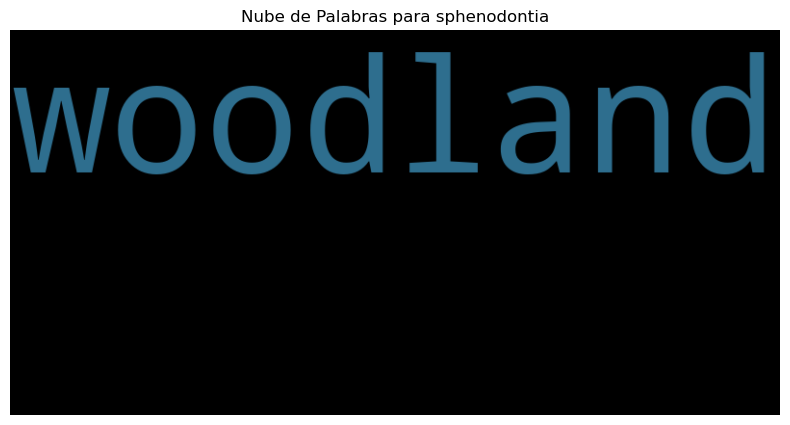

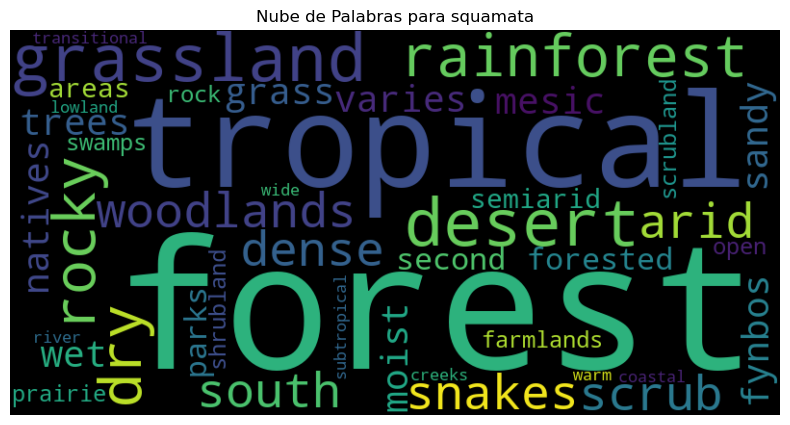

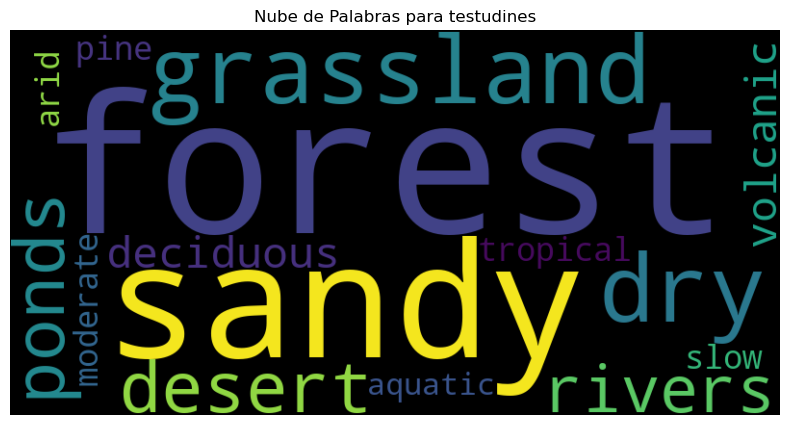

In [13]:


# Eliminar las filas que contienen "Unknown" en 'characteristics_habitat_clave'
df_reptiles = df_reptiles[(df_reptiles['characteristics_habitat_clave'] != 'unknown') & (df_reptiles['taxonomy_order'] != 'unknown')]

# Agrupar por 'taxonomy_order' y generar una nube de palabras para cada grupo
for taxonomy_order, group_data in df_reptiles.groupby('taxonomy_order'):
    wordcloud_data = ' '.join(group_data['characteristics_habitat_clave'])
    
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_text(wordcloud_data)

    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Nube de Palabras para {taxonomy_order}")
    plt.show()


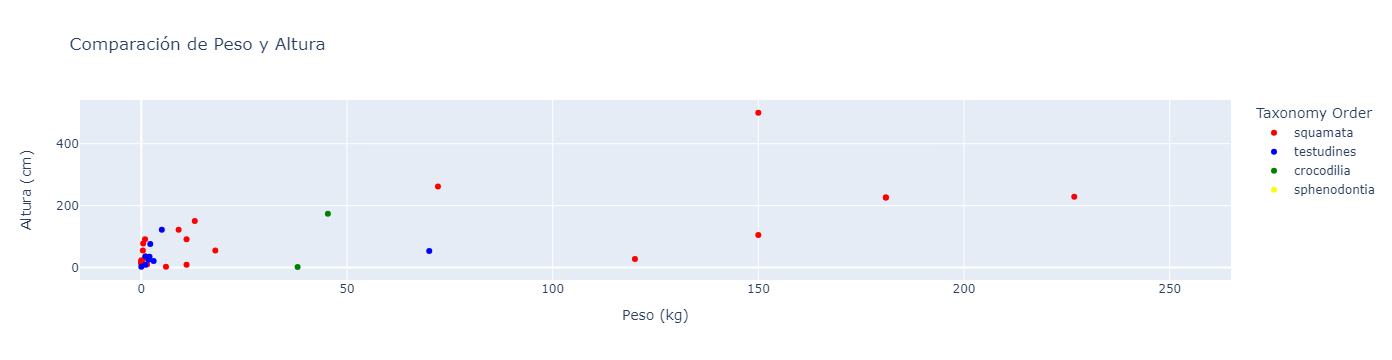

In [15]:
#Relacion de peso y altura

fig = px.scatter(df_reptiles, x='peso_en_kg', y='altura_cm', title='Comparación de Peso y Altura')

colors = {
    'squamata': 'red',  # Color para taxonomy_order 'A'
    'testudines': 'blue',  # Color para taxonomy_order 'B'
    'crocodilia': 'green',
    'sphenodontia': 'yellow'}# Color para taxonomy_order 'C'

fig = px.scatter(df_reptiles, x='peso_en_kg', y='altura_cm', color='taxonomy_order',color_discrete_map=colors, title='Comparación de Peso y Altura',
                 labels={'peso_en_kg': 'Peso (kg)', 'altura_cm': 'Altura (cm)', 'taxonomy_order': 'Taxonomy Order'},
                 hover_name='name')


fig.show()

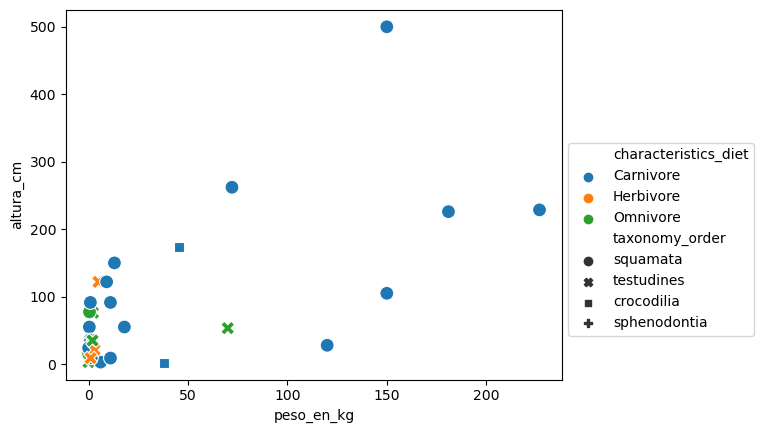

In [17]:
#Relacion entre dieta, peso, altura y taxonomia
sns.scatterplot(
                data  = df_reptiles,
                x     = "peso_en_kg", 
                y     = "altura_cm", 
                hue   = 'characteristics_diet',
                style = 'taxonomy_order',
                s     = 100
                )
plt.legend(loc='lower center', bbox_to_anchor = (1.2,0.1))
plt.show()

In [19]:
#Analisis de los colores segun su orden taxonomico

# Crear una función para clasificar los colores
def clasificar_color(num_colores):
    if num_colores <= 7:
        return 'unicolor'
    elif num_colores < 12:
        return 'bicolor'
    elif num_colores < 16:
        return 'tricolor'
    elif num_colores < 25:
        return 'cuatricolor'
    else:
        return 'multicolor'

# Contar el número de colores en la columna "characteristics_color"
df_reptiles['num_colores'] = df_reptiles['characteristics_color'].str.split('').apply(len)

# Aplicar la función de clasificación y crear una nueva columna "color_clasification"
df_reptiles['color_clasification'] = df_reptiles['num_colores'].apply(clasificar_color)

# Eliminar la columna temporal "num_colores" 
df_reptiles.drop('num_colores', axis=1, inplace=True)


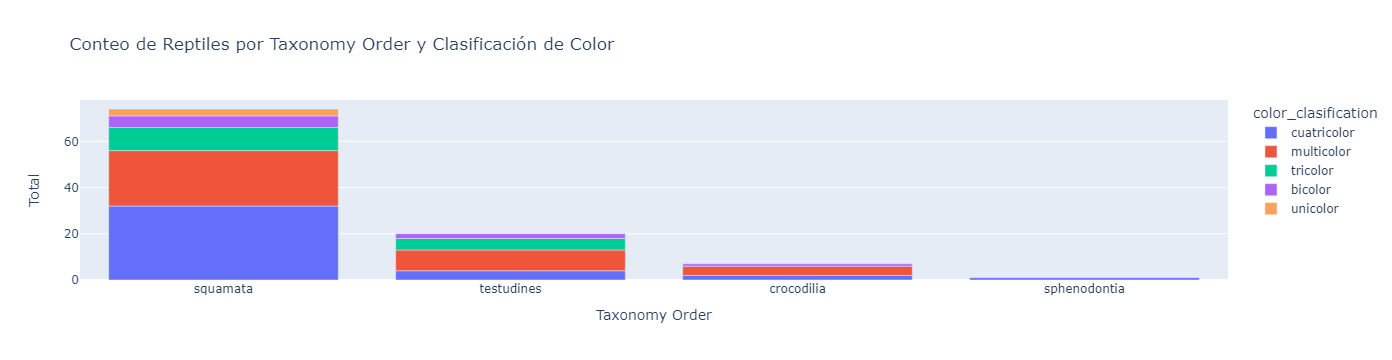

In [20]:
df_reptiles_filtrado = df_reptiles[(df_reptiles['color_clasification'] != 'unknown') & (df_reptiles['taxonomy_order'] != 'unknown')]

order = ['unicolor', 'bicolor', 'tricolor', 'cuatricolor', 'multicolor']

# Filtra el DataFrame para eliminar valores desconocidos y mantener solo las columnas necesarias
df_reptiles_filtrado = df_reptiles[(df_reptiles['color_clasification'] != 'unknown') & (df_reptiles['taxonomy_order'] != 'unknown')]

# Agrupa los datos filtrados por 'taxonomy_order' y 'color_classification' y cuenta el número de ocurrencias
df_agrupado = df_reptiles_filtrado.groupby(['taxonomy_order', 'color_clasification']).size().reset_index(name='count')

# Ordena el DataFrame según el orden deseado para las clasificaciones de color
df_agrupado['color_clasification'] = pd.Categorical(df_agrupado['color_clasification'], categories=order, ordered=True)

# Ordena el DataFrame por 'count' (total) de mayor a menor
df_agrupado = df_agrupado.sort_values(by='count', ascending=False)

# Crea el gráfico de barras apiladas
fig = px.bar(df_agrupado, x='taxonomy_order', y='count', color='color_clasification',
             title='Conteo de Reptiles por Taxonomy Order y Clasificación de Color',
             labels={'count': 'Total'})

# Personalización
fig.update_layout(xaxis_title='Taxonomy Order', yaxis_title='Total')
fig.update_xaxes(categoryorder='total descending')  # Ordenar de mayor a menor

# Muestra el gráfico
fig.show()


API 1:

In [2]:
alphabet1 = 'abcdefghijklmnopqrstuvwxyz'
alphabet2 = 'abcdefghijklmnopqrstuvwxyz'
# URL base de la API
api_base_url = 'https://api.api-ninjas.com/v1/animals?name={}'

# Tu clave de API
api_key = '6WeQhgR8yLhN+d1dDAdZ2Q==IoEiNbVRbrPJGVrz'

animal_data = []
for letter in tqdm(alphabet1):
    api_url = api_base_url.format(letter)
    response = requests.get(api_url, headers={'X-Api-Key': api_key})
    
    if response.status_code == requests.codes.ok:
        data = response.json()
        animal_data.extend(data)
    else:
        print(f"Error para la letra {letter}:", response.status_code, response.text)  # Utiliza tqdm para mostrar la barra de progreso
        
    for letra in tqdm(alphabet2):
        api_url = api_base_url.format(letter + letra)
        response = requests.get(api_url, headers={'X-Api-Key': api_key})
        
        if response.status_code == requests.codes.ok:
            data = response.json()
            animal_data.extend(data)
        else:
            print(f"Error para la letra {letter}:", response.status_code, response.text)

100%|██████████| 26/26 [09:33<00:00, 22.04s/it]


In [4]:
df = pd.DataFrame(animal_data)
# Dividir la columna 'taxonomy' en campos separados
df_taxonomy = pd.json_normalize(df['taxonomy'])
df_taxonomy.columns = ['taxonomy_' + col for col in df_taxonomy.columns]
# Dividir la columna 'characteristics' en campos separados
df_characteristics = pd.json_normalize(df['characteristics'])
df_characteristics.columns = ['characteristics_' + col for col in df_characteristics.columns]
# Eliminar las columnas originales 'taxonomy' y 'characteristics
df = df.drop(['taxonomy', 'characteristics'], axis=1)
# Concatenar los DataFrames de características y taxonomía
df = pd.concat([df, df_taxonomy, df_characteristics], axis=1)

print(df.shape)

(26954, 58)


In [6]:
df.drop_duplicates(subset=['name'], inplace=True)
df.reset_index(inplace=True)
df = df.drop(['index'], axis=1)

API 2:

In [8]:
#Establece la URL base de la API de GBIF
base_url = "https://api.gbif.org/v1/species/search"

#Define el parámetro para el reino "Animalia"
params = {"kingdom": "Animalia", "limit": 300}  # Puedes ajustar el valor de "limit" según tus necesidades

#Inicializa una lista para almacenar los datos
all_data = []

#Variable para rastrear la página actual
page = 1

while True:
    # Agrega el parámetro de paginación a la consulta
    params["offset"] = (page - 1) * params["limit"]

    # Realiza la solicitud GET a la API de GBIF
    response = requests.get(base_url, params=params)
    sleep(1)

    if response.status_code == 200:
        data = response.json()
        # Agrega los datos de la página actual a la lista de datos
        all_data.extend(data["results"])

        # Verifica si hay más páginas
        if len(data["results"]) < params["limit"]:
            break  # No hay más datos, así que salimos del bucle
        else:
            page += 1  # Pasamos a la siguiente página
    else:
        print("Error en la solicitud/final de la extracción:", response.status_code)
        break

df_data = pd.DataFrame(all_data)

Error en la solicitud/final de la extracción: 404


In [9]:
df_data.drop(['key', 'nameKey', 'datasetKey', "kingdomKey", 'constituentKey', 'nubKey','scientificName', 'canonicalName', 'authorship', 'nameType',
       'taxonomicStatus', 'rank', 'origin', 'nomenclaturalStatus', 'threatStatuses', 'descriptions',
       'vernacularNames', 'synonym', 'higherClassificationMap', 'extinct',
       'parentKey', 'parent', 'phylumKey', 'publishedIn',
       'acceptedKey', 'accepted', 'classKey', 'orderKey', 'familyKey', 'genusKey', 'speciesKey',
       'basionymKey', 'basionym', 'numDescendants', 'numOccurrences'], axis = 1, inplace= True)

df_data.dropna(subset=['habitats', 'phylum', 'class',
       'order', 'family', 'genus', 'species'], how='any', inplace =True)

df_data = df_data[df_data['kingdom'] == 'Animalia'].reset_index()

df_data.drop("index", axis = 1, inplace=True)

df_data = df_data.rename(columns={'kingdom': 'taxonomy_kingdom',
                        'habitats': 'characteristics_habitat',
                        'phylum': 'taxonomy_phylum',
                        'class': 'taxonomy_class',
                        'order': 'taxonomy_order',
                        'family': 'taxonomy_family',
                        'genus': 'taxonomy_genus',
                        'species': 'taxonomy_scientific_name',
                        })

columnas_faltan = ['name', 'locations','characteristics_gestation_period','characteristics_prey', 'characteristics_name_of_young', 'characteristics_group_behavior', 'characteristics_estimated_population_size', 'characteristics_biggest_threat', 'characteristics_most_distinctive_feature', 'characteristics_other_name(s)', 'characteristics_diet', 'characteristics_average_litter_size', 'characteristics_lifestyle', 'characteristics_common_name', 'characteristics_number_of_species', 'characteristics_location', 'characteristics_slogan', 'characteristics_group', 'characteristics_color', 'characteristics_skin_type', 'characteristics_top_speed', 'characteristics_lifespan', 'characteristics_weight', 'characteristics_length', 'characteristics_age_of_sexual_maturity', 'characteristics_age_of_weaning', 'characteristics_litter_size', 'characteristics_predators', 'characteristics_type', 'characteristics_height', 'characteristics_distinctive_feature', 'characteristics_temperament', 'characteristics_training', 'characteristics_wingspan', 'characteristics_incubation_period', 'characteristics_age_of_fledgling', 'characteristics_average_clutch_size', 'characteristics_venomous', 'characteristics_aggression', 'characteristics_main_prey', 'characteristics_water_type', 'characteristics_age_of_independence', 'characteristics_average_spawn_size', 'characteristics_nesting_location', 'characteristics_age_of_molting', 'characteristics_favorite_food', 'characteristics_origin', 'characteristics_migratory', 'characteristics_optimum_ph_level', 'characteristics_special_features']
for columna in columnas_faltan:
    df_data[columna] = None 

In [70]:
columnas_ordenadas = ['name', 'locations', 'taxonomy_kingdom', 'taxonomy_phylum',
       'taxonomy_class', 'taxonomy_order', 'taxonomy_family', 'taxonomy_genus',
       'taxonomy_scientific_name', 'characteristics_prey',
       'characteristics_name_of_young', 'characteristics_group_behavior',
       'characteristics_estimated_population_size',
       'characteristics_biggest_threat',
       'characteristics_most_distinctive_feature',
       'characteristics_other_name(s)', 'characteristics_gestation_period',
       'characteristics_habitat', 'characteristics_diet',
       'characteristics_average_litter_size', 'characteristics_lifestyle',
       'characteristics_common_name', 'characteristics_number_of_species',
       'characteristics_location', 'characteristics_slogan',
       'characteristics_group', 'characteristics_color',
       'characteristics_skin_type', 'characteristics_top_speed',
       'characteristics_lifespan', 'characteristics_weight',
       'characteristics_length', 'characteristics_age_of_sexual_maturity',
       'characteristics_age_of_weaning', 'characteristics_litter_size',
       'characteristics_predators', 'characteristics_type',
       'characteristics_height', 'characteristics_distinctive_feature',
       'characteristics_temperament', 'characteristics_training',
       'characteristics_wingspan', 'characteristics_incubation_period',
       'characteristics_age_of_fledgling',
       'characteristics_average_clutch_size', 'characteristics_venomous',
       'characteristics_aggression', 'characteristics_main_prey',
       'characteristics_water_type', 'characteristics_age_of_independence',
       'characteristics_average_spawn_size',
       'characteristics_nesting_location', 'characteristics_age_of_molting',
       'characteristics_favorite_food', 'characteristics_origin',
       'characteristics_migratory', 'characteristics_optimum_ph_level',
       'characteristics_special_features']

In [71]:
df_data = df_data[columnas_ordenadas]

In [72]:
# Concatenar los DataFrames por filas
df = pd.concat([df, df_data], axis=0)

# Reiniciar los índices después de la concatenación
df = df.reset_index(drop=True)

In [74]:
df.to_csv('animal_info.csv', index=False)

- CREACIÓN DE DFS POR GRUPO DE ANIMAL:

In [75]:
df = pd.read_csv("animal_info.csv")
df.shape

(2385, 58)

In [76]:
## Agrupa el DataFrame original por la columna 'class'
grupos = df.groupby('taxonomy_class')

## Crea una lista para almacenar los DataFrames resultantes
dfs_por_clase = []

# Itera sobre los grupos
for nombre_clase, grupo in grupos:
    # Elimina las columnas con valores nulos en este grupo
    grupo_sin_nulos = grupo.dropna(axis=1, how= "all")
    # Agrega el DataFrame sin nulos a la lista
    dfs_por_clase.append(grupo_sin_nulos)

In [77]:
#vemos longitud de cada df de cada clase de animal y contamos si tenemos las mismas filas en total que teniamos antes
cantidad = 0
for i in dfs_por_clase:
    print(i.shape)
    cantidad = cantidad + i.shape[0]
print(f"la cantidad de filas o datos son {cantidad}")

(124, 53)
(1, 32)
(46, 49)
(2, 23)
(27, 42)
(1, 30)
(191, 53)
(3, 33)
(8, 40)
(1, 16)
(33, 46)
(3, 33)
(1, 24)
(1, 17)
(1, 19)
(817, 8)
(5, 40)
(3, 30)
(1, 25)
(81, 47)
(1, 29)
(16, 45)
(790, 51)
(1, 25)
(1, 27)
(196, 52)
(2, 29)
(3, 39)
la cantidad de filas o datos son 2360


In [111]:
#Las clases de animales que nos interesan:
dfs_por_clase[0].shape, dfs_por_clase[2].shape, dfs_por_clase[6].shape, dfs_por_clase[22].shape, dfs_por_clase[25].shape, dfs_por_clase[7].shape, dfs_por_clase[8].shape, dfs_por_clase[10].shape, dfs_por_clase[16].shape, dfs_por_clase[17].shape, dfs_por_clase[21].shape, dfs_por_clase[15].shape

((124, 53),
 (46, 49),
 (191, 53),
 (790, 51),
 (196, 52),
 (3, 33),
 (8, 40),
 (33, 46),
 (5, 40),
 (3, 30),
 (16, 45),
 (817, 8))

In [112]:
Actinopterygii = dfs_por_clase[0]
df_anfibios = dfs_por_clase[2]
df_aves = dfs_por_clase[6]
df_mamiferos = dfs_por_clase[22]
df_reptiles = dfs_por_clase[25]
Bilvavia = dfs_por_clase[7]
Cephalopoda = dfs_por_clase[8]
Chondrichthyes = dfs_por_clase[10]
Gastropoda = dfs_por_clase[16]
Hydrozoa = dfs_por_clase[17]
Malacostraca = dfs_por_clase[21]
df_microorganismos = dfs_por_clase[15]

df_ocean = pd.DataFrame()
df_ocean = pd.concat([df_ocean, Actinopterygii, Bilvavia, Cephalopoda, Chondrichthyes, Gastropoda, Hydrozoa, Malacostraca], axis=0)

df_anfibios.reset_index(drop = True, inplace=True)
df_ocean.reset_index(drop = True, inplace=True)
df_aves.reset_index(drop= True, inplace=True)
df_mamiferos.reset_index(drop = True, inplace=True)
df_reptiles.reset_index(drop = True, inplace=True)
#df_microorganismos.reset_index(drop=True, inplace=True)

- OBTENCION DE LAS LISTAS DE DOMESTICOS Y NO DOMESTICOS POR WEB SCRAPING Y SU TRATAMIENTO
- PRIMERO OBTENDREMOS LOS DOMESTICOS

In [113]:
url = "https://concepto.de/animales-domesticos/"
response = requests.get(url)
#print(response,bool(response))
soup = BeautifulSoup(response.text, "html.parser")

filtrado = soup.find_all("li")
lista_texto = []

for texto in filtrado:
    lista_texto.append(texto.text)
    
elemento_a_buscar = "Perro (Canis lupus familiaris)."
indice = lista_texto.index(elemento_a_buscar)
indice

#Ya tengo el indice de perro

elemento_a_buscar2 = "Loro domÃ©stico (Psittacidae spp.)"
indice = lista_texto.index(elemento_a_buscar2)
indice
#Este es el ultimo animal de la lista

# Ahora igualo mi lista_texto con la nueva lista con los indices que me interesan

lista_final=lista_texto[62:102]
lista_domestico = lista_final

for i,a in enumerate(lista_domestico):
    if("Ã³" in a):
        a=a.replace("Ã³","o")
        lista_domestico[i]=a
    elif("Ã¡" in a):
        a=a.replace("Ã¡","a")
        lista_domestico[i]=a

- VAMOS A OBTENER LOS QUE AHORA NO SON DOMESTICOS POR LA NUEVA LEY

In [114]:
url="https://www.superdeporte.es/fuera-de-juego/2023/09/24/son-mascotas-podras-casa-2023-92502088.html"
response = requests.get(url)
#print(response,bool(response))
soup = BeautifulSoup(response.text, "html.parser")
lista=soup.find("ul",class_="article-body__text article-list article-list--unordered").text.split("\n")
lista2=list()
for i in range(2,len(lista),3):
    lista2.append(lista[i].split(".")[0])

#SEPARANDO LAS AVES
lista_aves=[]
lista_aves.append(lista2[1].split(",")[0].split(":")[1].split(" ")[1].capitalize())
lista_aves.append(lista2[1].split(",")[1].split(" ")[1].capitalize())
lista_aves.append(lista2[1].split(",")[2].split(" ")[1].capitalize())
#SEPARANDO LOS REPTILES
lista_reptiles=[]
r=lista2[4].split(",")[3].split(" ")
r[1]+" "+r[2]+" "+r[3].capitalize()
lista_reptiles.append(lista2[4].split(" ")[2].split(",")[0].capitalize())
lista_reptiles.append(r[1]+" "+r[2]+" "+r[3].capitalize())
lista_reptiles.append(lista2[4].split(" ")[4].split(",")[0].capitalize())
lista_reptiles.append(lista2[4].split(",")[3].capitalize())
#EL POP ES PARA ELIMINAR CAMALEONES O GEKOS CON GEKO EN MAYUSCULA
lista_reptiles.pop(3)
#SEPARANDO LOS ROEDORE
lista_roedore=[]
lista_roedore.append(lista2[5].split(",")[0].split(": ")[1].capitalize())
lista_roedore.append(lista2[5].split(", ")[1].capitalize())
lista_roedore.append(lista2[5].split(", ")[2].capitalize())
lista_roedore.append(lista2[5].split(", ")[3].capitalize())

lista_no_domesticos=[]
lista_no_domesticos.append(lista2[0].capitalize())
lista_no_domesticos.extend(lista_aves)
lista_no_domesticos.append(lista2[2].capitalize())
lista_no_domesticos.append(lista2[3].capitalize())
lista_no_domesticos.extend(lista_reptiles)
lista_no_domesticos.extend(lista_roedore)
lista_no_domesticos.append(lista2[6].capitalize())
lista_no_domesticos[-2]="Raton"
lista_no_domesticos.append("Hamster")

-AHORA FILTRAMOS PARA VER CUALES DE LOS QUE ANTES ERAN DOMESTICOS YA NO SON LEGALES POR LEY

In [115]:
lista_ya_no_son=[]
for a in lista_no_domesticos:
    for b in lista_domestico:
        if b.startswith(a.split("s")[0]):
            lista_ya_no_son.append(b)

for i,a in enumerate(lista_ya_no_son):
    lista_ya_no_son[i]=a.split( "(")[1].split(")")[0]

In [116]:
dic_aves={}
dic_mamiferos={}
dic_reptiles={}
dic_ocean={}
dic_anfibios={}

lista_xonomy=df_aves["taxonomy_scientific_name"].to_list()
for a in lista_ya_no_son:
    if (a in lista_xonomy):
        dic_aves[a]=df_aves[df_aves["taxonomy_scientific_name"]==a].index.tolist()

lista_xonomy=df_mamiferos["taxonomy_scientific_name"].to_list()
for a in lista_ya_no_son:
    if (a in lista_xonomy):
        dic_mamiferos[a]=df_mamiferos[df_mamiferos["taxonomy_scientific_name"]==a].index.tolist()

lista_xonomy=df_reptiles["taxonomy_scientific_name"].to_list()
for a in lista_ya_no_son:
    if (a in lista_xonomy):
        dic_reptiles[a]=df_reptiles[df_reptiles["taxonomy_scientific_name"]==a].index.tolist()

lista_xonomy=df_anfibios["taxonomy_scientific_name"].to_list()
for a in lista_ya_no_son:
    if (a in lista_xonomy):
        dic_anfibios[a]=df_anfibios[df_anfibios["taxonomy_scientific_name"]==a].index.tolist()

lista_xonomy=df_ocean["taxonomy_scientific_name"].to_list()
for a in lista_ya_no_son:
    if (a in lista_xonomy):
        dic_ocean[a]=df_ocean[df_ocean["taxonomy_scientific_name"]==a].index.tolist()

- CREANDO LA COLUMNA DOMESTICOS

In [117]:
df_aves["domesticos"]=1
df_mamiferos["domesticos"]=1
df_reptiles["domesticos"]=1
df_anfibios["domesticos"]=1
df_ocean["domesticos"]=1

for keys,values in dic_aves.items():
    df_aves.loc[values,"domesticos"]=0
for keys,values in dic_mamiferos.items():
    df_mamiferos.loc[values,"domesticos"]=0   
for keys,values in dic_reptiles.items():
    df_reptiles.loc[values,"domesticos"]=0   
for keys,values in dic_anfibios.items():
    df_anfibios.loc[values,"domesticos"]=0   
for keys,values in dic_ocean.items():
    df_ocean.loc[values,"domesticos"]=0  

OBTENCION DE ANIMALES PROTEGIDOS DESDE EL BOE:

In [118]:
df_protegidos = pd.read_excel("tablalesrpe_ceea_ordented2023_eidos21062023_tcm30-201186.xlsx")
df_protegidos.dropna(subset=['Grupo taxonómico/ Nombre científico', 'TaxonID\n', "Nombre común"], inplace=True)
# Encuentra los índices donde los valores tienen más de tres palabras
indices = df_protegidos[df_protegidos['Grupo taxonómico/ Nombre científico'].str.split().str.len() > 8].index
for i in indices:
    df_protegidos["Grupo taxonómico/ Nombre científico"][i]=df_protegidos["Grupo taxonómico/ Nombre científico"][i].replace("Se incluyen todas las especies de la Familia", "")
    df_protegidos["Grupo taxonómico/ Nombre científico"][i]=df_protegidos["Grupo taxonómico/ Nombre científico"][i].replace("Todas las especies del género", "")
    df_protegidos["Grupo taxonómico/ Nombre científico"][i]=df_protegidos["Grupo taxonómico/ Nombre científico"][i].replace(", salvo Cystoseira compressa", "")
    df_protegidos["Grupo taxonómico/ Nombre científico"][i]=df_protegidos["Grupo taxonómico/ Nombre científico"][i].replace("incluyen todas las especies del género", "")

# expresión regular para encontrar paréntesis con un número dentro
patron = r'\(\d+\)'
# Encontrar los índices donde el patrón aparece en la columna
indices = df_protegidos[df_protegidos['Grupo taxonómico/ Nombre científico'].str.contains(patron)].index

for i in indices:
    df_protegidos["Grupo taxonómico/ Nombre científico"][i] = re.sub(patron, '', df_protegidos['Grupo taxonómico/ Nombre científico'][i])

lista_taxonomías_protegidas = df_protegidos['Grupo taxonómico/ Nombre científico'].to_list()

EMPLEAMOS LA MISMA LÓGICA PARA ANIMALES PROTEGIDOS

In [119]:
diccionario_mamiferos = {}
diccionario_aves = {}
diccionario_anfibios = {}
diccionario_ocean = {}
diccionario_reptiles = {}

lista_cientifico = df_aves["taxonomy_scientific_name"].tolist()
#INDICES DONDE LA ESPECIE DE AVE ESTÁ PROTEGIDA
for a in lista_cientifico:
    if a in lista_taxonomías_protegidas:
        diccionario_aves[a] = df_aves[(df_aves["taxonomy_scientific_name"] == a)].index.tolist()

lista_cientifico = df_anfibios["taxonomy_scientific_name"].tolist()
#INDICES DONDE LA ESPECIE ANFIBIA ESTÁ PROTEGIDA
for a in lista_cientifico:
    if a in lista_taxonomías_protegidas:
        diccionario_anfibios[a] = df_anfibios[(df_anfibios["taxonomy_scientific_name"] == a)].index.tolist()

lista_cientifico = df_mamiferos["taxonomy_scientific_name"].tolist()
#INDICES DONDE LA ESPECIE MAMIFEROS ESTÁ PROTEGIDA
for a in lista_cientifico:
    if a in lista_taxonomías_protegidas:
        
        diccionario_mamiferos[a] = df_mamiferos[(df_mamiferos["taxonomy_scientific_name"] == a)].index.tolist()

lista_cientifico = df_ocean["taxonomy_scientific_name"].tolist()
#INDICES DONDE LA ESPECIE OCEANICA ESTÁ PROTEGIDA
for a in lista_cientifico:
    if a in lista_taxonomías_protegidas:
        diccionario_ocean[a] = df_ocean[(df_ocean["taxonomy_scientific_name"] == a)].index.tolist()

lista_cientifico = df_reptiles["taxonomy_scientific_name"].tolist()
#INDICES DONDE LA ESPECIE REPTIL ESTÁ RPTEGIDA
for a in lista_cientifico:
    if a in lista_taxonomías_protegidas:
        diccionario_reptiles[a] = df_reptiles[(df_reptiles["taxonomy_scientific_name"] == a)].index.tolist()

#LOS MICROORGANISMOS NO ENTRAN EN LA CATEGORÍA DE ESPECIES PROTEGIDAS

-MODIFICANDO COLUMNA DE DOMESTICOS, LAS ESPECIES PROTEGIDAS NO SON DOMESTICAS POR LA LEY:

In [120]:
for clave, valores in diccionario_reptiles.items():
    # Establecer 1 en los índices correspondientes
    df_reptiles.loc[valores, 'domesticos'] = 0

for clave, valores in diccionario_ocean.items():
    # Establecer 1 en los índices correspondientes
    df_ocean.loc[valores, 'domesticos'] = 0

for clave, valores in diccionario_anfibios.items():
    # Establecer 1 en los índices correspondientes
    df_anfibios.loc[valores, 'domesticos'] = 0

for clave, valores in diccionario_mamiferos.items():
    # Establecer 1 en los índices correspondientes
    df_mamiferos.loc[valores, 'domesticos'] = 0

for clave, valores in diccionario_aves.items():
    # Establecer 1 en los índices correspondientes
    df_aves.loc[valores, 'domesticos'] = 0

-CREAMOS UNA COLUMNA DE PROTEGIDOS Y APLICAMOS LA MISMA LOGICA

In [121]:
df_reptiles['protegidos'] = 0
# Iterar sobre las claves y valores del diccionario
for clave, valores in diccionario_reptiles.items():
    # Establecer 1 en los índices correspondientes
    df_reptiles.loc[valores, 'protegidos'] = 1

df_ocean['protegidos'] = 0
# Iterar sobre las claves y valores del diccionario
for clave, valores in diccionario_ocean.items():
    # Establecer 1 en los índices correspondientes
    df_ocean.loc[valores, 'protegidos'] = 1

df_anfibios['protegidos'] = 0
# Iterar sobre las claves y valores del diccionario
for clave, valores in diccionario_anfibios.items():
    # Establecer 1 en los índices correspondientes
    df_anfibios.loc[valores, 'protegidos'] = 1

df_mamiferos['protegidos'] = 0
# Iterar sobre las claves y valores del diccionario
for clave, valores in diccionario_mamiferos.items():
    # Establecer 1 en los índices correspondientes
    df_mamiferos.loc[valores, 'protegidos'] = 1

df_aves['protegidos'] = 0
# Iterar sobre las claves y valores del diccionario
for clave, valores in diccionario_aves.items():
    # Establecer 1 en los índices correspondientes
    df_aves.loc[valores, 'protegidos'] = 1

OBTENEMOS LISTA DE ANIMALES EXÓTICOS DEL BOE:

In [122]:
df = pd.read_excel("exoticos.xlsx")
df = df.dropna(subset = ["Grupo taxonómico", "Nombre científico CEEEI /BOE"])
df_comparacion = df[["Grupo taxonómico", "Nombre científico CEEEI /BOE"]] #dataFrame solo con las columnas de interes
lista_exoticos=df_comparacion["Nombre científico CEEEI /BOE"].to_list() #Guardo en una lista sólo el nombre científico

#Genero una lista con los elementos de lista_exoticos la cual vamos a comparar con cada dataframe
nombresCientificos = []
for element in lista_exoticos:
    nombresCientificos.append(element.split()[0]+" "+element.split()[1])

In [123]:
lista_nombre_mamifero = df_mamiferos["taxonomy_scientific_name"].to_list()
lista_peces_df = df_ocean["taxonomy_scientific_name"].to_list()
lista_nombre_reptiles = df_reptiles["taxonomy_scientific_name"].to_list()
lista_nombre_aves = df_aves["taxonomy_scientific_name"].to_list()
lista_nombre_anfibios = df_anfibios["taxonomy_scientific_name"].to_list()

mamiferos_protegidos = {}
for x in lista_nombre_mamifero:
    for y in nombresCientificos:
        if y == x:
            mamiferos_protegidos[y] = df_mamiferos[(df_mamiferos["taxonomy_scientific_name"] == y)].index.tolist()   

peces_exoticos_protegidos = {}
for x in lista_peces_df:
    for y in nombresCientificos:
        if y == x:
            peces_exoticos_protegidos[y] = df_ocean[(df_ocean["taxonomy_scientific_name"] == y)].index.tolist()  

reptiles_exoticos_protegidos = {}
for x in lista_nombre_reptiles:
    for y in nombresCientificos:
        if y == x:
            reptiles_exoticos_protegidos[y] = df_reptiles[(df_reptiles["taxonomy_scientific_name"] == y)].index.tolist()

aves_exoticas_protegidas = {}
for x in lista_nombre_aves:
    for y in nombresCientificos:
        if y == x:
            aves_exoticas_protegidas[y] = df_aves[(df_aves["taxonomy_scientific_name"] == y)].index.tolist()

anfibios_exoticos_protegidas = {}
for x in lista_nombre_anfibios:
    for y in nombresCientificos:
        if y == x:
            anfibios_exoticos_protegidas[y] = df_anfibios[(df_anfibios["taxonomy_scientific_name"] == y)].index.tolist()

CREANDO COLUMNA EXÓTICOS

In [124]:
df_reptiles['exoticos'] = 0
# Iterar sobre las claves y valores del diccionario
for clave, valores in reptiles_exoticos_protegidos.items():
    # Establecer 1 en los índices correspondientes
    df_reptiles.loc[valores, 'exoticos'] = 1

df_ocean['exoticos'] = 0
# Iterar sobre las claves y valores del diccionario
for clave, valores in peces_exoticos_protegidos.items():
    # Establecer 1 en los índices correspondientes
    df_ocean.loc[valores, 'exoticos'] = 1

df_anfibios['exoticos'] = 0
# Iterar sobre las claves y valores del diccionario
for clave, valores in anfibios_exoticos_protegidas.items():
    # Establecer 1 en los índices correspondientes
    df_anfibios.loc[valores, 'exoticos'] = 1

df_mamiferos['exoticos'] = 0
# Iterar sobre las claves y valores del diccionario
for clave, valores in mamiferos_protegidos.items():
    # Establecer 1 en los índices correspondientes
    df_mamiferos.loc[valores, 'exoticos'] = 1

df_aves['exoticos'] = 0
# Iterar sobre las claves y valores del diccionario
for clave, valores in aves_exoticas_protegidas.items():
    # Establecer 1 en los índices correspondientes
    df_aves.loc[valores, 'exoticos'] = 1

MODIFICANDO COLUMNA DE DOMESTICOS, SI LOS ANIMALES APARECEN EN LA LISTA DE EXÓTICOS

In [125]:
for clave, valores in reptiles_exoticos_protegidos.items():
    # Establecer 1 en los índices correspondientes
    df_reptiles.loc[valores, 'domesticos'] = 0

for clave, valores in peces_exoticos_protegidos.items():
    # Establecer 1 en los índices correspondientes
    df_ocean.loc[valores, 'domesticos'] = 0

for clave, valores in anfibios_exoticos_protegidas.items():
    # Establecer 1 en los índices correspondientes
    df_anfibios.loc[valores, 'domesticos'] = 0

for clave, valores in mamiferos_protegidos.items():
    # Establecer 1 en los índices correspondientes
    df_mamiferos.loc[valores, 'domesticos'] = 0

for clave, valores in aves_exoticas_protegidas.items():
    # Establecer 1 en los índices correspondientes
    df_aves.loc[valores, 'domesticos'] = 0

-CREAMOS UNA LISTA DE LAS COLUMNAS DE CADA DF PARA TENER EL ORDEN DE LAS COLUMNAS QUE QUEREMOS CUANDO USEMOS AIRTABLE

In [165]:
df_animal = pd.read_csv("animal_info.csv")

In [166]:
#lista de ordenes de columnas:
orden_anfibios = df_anfibios.columns.to_list()
orden_ocean = df_ocean.columns.to_list()
orden_aves = df_aves.columns.to_list()
orden_mamiferos = df_mamiferos.columns.to_list()
orden_reptiles = df_reptiles.columns.to_list()
orden_microorganismos = df_microorganismos.columns.to_list()
orden_animal = df_animal.columns.to_list()

In [127]:
df_anfibios.to_csv("Anfibios.csv", index = False)
df_ocean.to_csv("Ocean.csv", index = False)
df_aves.to_csv("Aves.csv", index = False)
df_mamiferos.to_csv("Mamifero.csv", index = False)
df_reptiles.to_csv("Reptiles.csv", index = False)
df_microorganismos.to_csv("Microorganismos.csv", index = False)

AIRTABLE:

In [123]:
def get_secrets(path:str)->dict:
    '''
    This functions receives a text file with the secrets of an API, and returns it
    '''
    with open (path, 'r') as file:
        secrets = file.read()
    credentials = (
        {
        secreto.split(' = ')[0]:secreto.split(' = ')[1] 
        for secreto in secrets.split('\n')
        }
    )
    
    return credentials

In [124]:
based_id_aves = "appn5PRUsQu0hvd4S"
table_id_aves = "tbl2J1Y8yYp4jdaxQ"
based_id_mamiferos = "apponUK7ETg29y6Rx"
table_id_mamiferos = "tblXS5TgGaJXkRIRb"
based_id_reptiles = "appXaa0Wy2QCzX2XB"
table_id_reptiles = "tblXBNvYu6e2vEZBI"
based_id_anfibios = "appQCTAoNwlhYEpNg"
table_id_anfibios = "tblRhZbYeGVMVxwem"
based_id_ocean = "appZzKqRTC6npCOmO"
table_id_ocean = "tblwTGDr2Xwmqzuil"
based_id_microorganismos = "appnh4HMvA9OLilUN"
table_id_microorganismos = "tblj9km1fB0fh0OZs"
based_id_animals = "apppZCoOQoULJ7qEE"
table_id_animals = "tblMdGB9gn0TlVrjl"

In [125]:
lista_based = [based_id_aves,based_id_mamiferos,based_id_anfibios,based_id_ocean,based_id_microorganismos, based_id_animals]
lista_table = [table_id_aves,table_id_mamiferos,table_id_anfibios,table_id_ocean,table_id_microorganismos, table_id_animals]
lista_csv = ["Aves.csv", "Mamifero.csv", "Anfibios.csv", "Ocean.csv", "Microorganismos.csv", "animal_info.csv"]

In [76]:
credentials = get_secrets('token.txt')

api_key = credentials["token"]
# Headers
headers = {"Authorization" : f"Bearer {api_key}",
           "Content-Type"  : "application/json"}

pprint(headers)

{'Authorization': 'Bearer '
                  'patTLUYARsW8bKjq7.2435d7dcba8dd46cc0118e36c95faddcd31f053b44e5b5122743cdd35e2bd3e9',
 'Content-Type': 'application/json'}


SUBIENDO TABLAS A AIRTABLE:

In [126]:
from airtable import Airtable
credentials = get_secrets('token.txt')
API_KEY = credentials["token"]

In [166]:
for base, table, csv in zip(lista_based, lista_table, lista_csv):
    base = Airtable(base, table, API_KEY)
    df = pd.read_csv(f'{csv}')
    for index, row in df.iterrows():
    
        data = row.to_dict()

        base.insert(data)

    print("Filas subidas exitosamente a Airtable.")

Filas subidas exitosamente a Airtable.
Filas subidas exitosamente a Airtable.
Filas subidas exitosamente a Airtable.
Filas subidas exitosamente a Airtable.
Filas subidas exitosamente a Airtable.
Filas subidas exitosamente a Airtable.


PRIMERA PETICION A TABLA ANIMAL INFO DE EJEMPLO

In [127]:
def obtener_df(base_id,table_id,orden_columna):

    # Configura tus credenciales y la tabla de Airtable
    API_KEY = "patTLUYARsW8bKjq7.2435d7dcba8dd46cc0118e36c95faddcd31f053b44e5b5122743cdd35e2bd3e9"

    BASE_ID = base_id
    TABLE_NAME = table_id

    # Conecta con tu base de datos en Airtable
    base = Airtable(BASE_ID, TABLE_NAME, API_KEY)

    # Obtiene todos los registros de la tabla
    records = base.get_all()

    # Convierte los registros en una lista de diccionarios
    data = [record['fields'] for record in records]

    # Crea un DataFrame a partir de los datos
    return pd.DataFrame(data, columns=orden_columna)

In [135]:
df_anfibios = obtener_df(based_id_anfibios, table_id_anfibios, orden_anfibios)
df_reptiles = obtener_df(based_id_reptiles, table_id_reptiles, orden_reptiles)
df_aves = obtener_df(based_id_aves, table_id_aves, orden_aves)
df_mamiferos = obtener_df(based_id_mamiferos, table_id_mamiferos, orden_reptiles)
df_microorganismos = obtener_df(based_id_microorganismos, table_id_microorganismos, orden_microorganismos)
df_ocean = obtener_df(based_id_ocean, table_id_ocean, orden_ocean)
df_animal = obtener_df(based_id_animals, table_id_animals, orden_animal)

In [136]:
df_anfibios.to_csv("Anfibios_air.csv", index = False)
df_ocean.to_csv("Ocean_air.csv", index = False)
df_aves.to_csv("Aves_air.csv", index = False)
df_mamiferos.to_csv("Mamifero_air.csv", index = False)
df_reptiles.to_csv("Reptiles_air.csv", index = False)
df_microorganismos.to_csv("Microorganismos_air.csv", index = False)
df_animal.to_csv("animal_info_air.csv", index = False)

**LIMPIEZA DFS Y ANALISIS**

**FUNCIONES PARA CAMBIAR LAS COLUMNAS DE PESO Y ESTATURA**

In [1]:
def convertirpesos(x)->float:
#POR SI TIENE EL KG EN LA SEGUNDA CIFRA
    if(re.search(r'(\d+)-(\d+)kg',x)):
        r=re.search(r'(\d+)-(\d+)kg', x)
        suma= float(r.group(1))+int(r.group(2))
        resul= (suma/2)
        return resul
#AHORA POR SI LO TIENE EN LOS DOS
    elif(re.search(r'\d+\.\d+kg - \d+\.\d+kg',x)):
        r1=re.search(r'\d+\.\d+kg - \d+\.\d+kg',x)
        n1=float(r1.group(0).split("kg")[0])
        n2=float(r1.group(0).split("kg")[1].split()[1])
        return (n1+n2)/2
    elif(re.search(r'(\d+)kg-(\d+)kg',x)):
        r=re.search(r'(\d+)kg-(\d+)kg',x)
        suma= float(r.group(1))+int(r.group(2))
        resul= (suma/2)
        return resul
#AHORA LOS MISMO PERO CON LBS
    elif(re.search(r'(\d+)lbs-(\d+)', x)):
        r=re.search(r'(\d+)lbs-(\d+)', x)
        primer_numero = float(r.group(1))*0.45359237
        segundo_numero = float(r.group(2))*0.45359237
        resul= (primer_numero+segundo_numero)/2
        return resul
#POR SI TIENE EL LBS EN LA SEGUNDA CIFRA
    elif(re.search(r'(\d+)-(\d+)lbs',x)):
        r=re.search(r'(\d+)-(\d+)lbs', x)
        primer_numero = float(r.group(1))*0.45359237
        segundo_numero = float(r.group(2))*0.45359237
        resul=  (primer_numero+segundo_numero)/2
        return resul
#AHORA POR SI LO TIENE EN LOS DOS(LBS)
    elif(re.search(r'(\d+)lbs-(\d+)lbs',x)):
        r=re.search(r'(\d+)lbs-(\d+)lbs',x)
        primer_numero = float(r.group(1))*0.45359237
        segundo_numero = float(r.group(2))*0.45359237
        resul=  (primer_numero+segundo_numero)/2
        return resul
    elif(re.search(r'\d+kg',x)):
        r=re.search(r'\d+kg',x)
        return r.group(0).split("kg")[0]
    elif(re.findall(r'(22[0-9]|2[3-9][0-9]|[3-8][0-9]{2}|900)g',x)):
        print("es aqui",x)
        try:
            r=re.findall(r'(22[0-9]|2[3-9][0-9]|[3-8][0-9]{2}|900)g',x)
            n=(float(r[0])+float(r[1]))/2
            return float(n/1000)
        except:
            r=re.findall(r'(22[0-9]|2[3-9][0-9]|[3-8][0-9]{2}|900)g',x)
            n=(float(r[0]))/2
            return float(n/1000)
    elif(re.findall(r'\b\d+\s*pounds\b',x)):
        r=re.findall(r'\b\d+\s*pounds\b',x)
        n=float(r[0].split()[0])*0.45359237
        return n
    elif(re.findall(r'\b\d+\s*lbs\b',x)):
        r=re.findall(r'\b\d+\s*lbs\b',x)
        n=float(r[0].split("lbs")[0])*0.45359237
        return n
    elif(re.findall(r'\b\d+g\b',x)):
        r=re.findall(r'\b\d+g\b',x)
        n=float(r[0].split("g")[0])/1000
        return n
    elif(re.findall(r'\b\d+\.\d+\s*ounces\b',x)):
        r=re.findall(r'\b\d+\.\d+\s*ounces\b',x)
        n=float(r[0].split()[0])/35.274
        return n
    elif(re.findall(r'\b\d+\.\d+\b',x)):
        try:
            r=re.findall(r'\b\d+\.\d+\b',x)
            n=(float(r[0]))+(float(r[1]))/2
            return n*0.45359237
        except:
            r=re.findall(r'\b\d+\.\d+\b',x)
            n=(float(r[0]))
            return n*0.45359237
    elif(re.findall(r'\b\d+\s*Lbs\b',x)):
        r=re.findall(r'\b\d+\s*Lbs\b',x)
        n=float(r[0].split()[0])*0.45359237
        return n
    elif ("lbs" in x ):
        if(x.split()[0].isnumeric()):
            n1=float(x.split()[0])*0.45359237
            return n1
        else:
            pass
        print(x,"elif de libras")
        return float(input())*0.45359237
    elif("pounds" in x):
        print(x,"elif de pounds")
        return float(input())*0.45359237
    elif("Unknown" in x):
        return np.nan
    elif("ounces" in x):
        print(x)
        c=int(input("1 numero o 2"))
        if(c==1):
            return float(input())
        elif(c==2):
            n1=float(input())*0.0283495
            n2=float(input())*0.0283495
            return (n1+n2)/2
    elif("tons" in x):
        print(x)
        c=int(input("1 numero o 2"))
        if(c==1):
            return (float(input())*1000)
        elif(c==2):
            n1=float(input())*1000
            n2=float(input())*1000
            print("resultado",(n1+n2)/2)
            return (n1+n2)/2
    else:
        print(x)
        c=int(input("1 numero o 2"))
        if(c==1):
            return float(input())
        elif(c==2):
            n1=float(input())
            n2=float(input())
            return (n1+n2)/2

In [99]:
def convertiraltura(x)->float:
    inches=2.54
    feet=30.48
    metrosTocm=100
    
  
    
    if("Unknow" in x):
        return np.nan
    elif(re.findall(r'\b\d+-\d+\s*inches\b',x)):
        r=re.findall(r'\b\d+-\d+\s*inches\b',x)
        n1=float(r[0].split()[0].split("-")[0])*inches
        n2=float(r[0].split()[0].split("-")[1])*inches
        return (n1+n2)/2
    elif(re.findall(r'\b\d+cm-\d+cm\b',x)):
        r=re.findall(r'\b\d+cm-\d+cm\b',x)
        n1=float(r[0].split("-")[0].split("cm")[0])
        n2=float(r[0].split("-")[1].split("cm")[0])
        return (n1+n2)/2
    elif(re.findall(r'\b\d+\s*to\s*\d+\s*feet\b',x)):
        try:
            r=re.findall(r'\b\d+\s*to\s*\d+\s*feet\b',x)
            n1=float(r[0].split()[0])*feet
            n2=float(r[0].split()[2])*feet
            return(n1+n2)/2
        except:
            print(x,"arregla este patron en donde feet")
    elif(re.findall(r'\b\d{1,3}cm\b',x)):
        try:
            r=re.findall(r'\b\d{1,3}cm\b',x)
            n1=float(r[0].split("cm")[0])
            n2=float(r[1].split("cm")[0])
            return (n1+n2)/2
        except:
            r=re.findall(r'\b\d{1,3}cm\b',x)
            n1=float(r[0].split("cm")[0])
            return n1
    elif(re.findall(r'\b(?:17|17\.\d|18)in\b',x)):
         
         r=re.findall(r'\b(?:17|17\.\d|18)in\b',x)
         n1=float(r[0].split("in")[0])*inches
         n2=float(r[1].split("in")[0])*inches
         return (n1+n2)/2
    elif(re.findall(r'\b\d\.\d-\d\.\dft\b',x)):
        r=re.findall(r'\b\d\.\d-\d\.\dft\b',x)
        n1=float(r[0].split("-")[0])*feet
        n2=float(r[0].split("-")[1].split("ft")[0])*feet
        return (n1+n2)/2
                        
    elif(re.findall(r'\d+\.\d+m',x)):
        try:
            r=re.findall(r'\d+\.\d+m',x)
            n1=float(r[0].split("m")[0])*metrosTocm
            n2=float(r[1].split("m")[0])*metrosTocm
            return (n1+n2)/2
        except:
            r=re.findall(r'\d+\.\d+m',x)
            n1=float(r[0].split("m")[0])*metrosTocm
            return n1
            
    elif(re.findall(r'(\d+\.\d+)-(\d+\.\d+) feet',x)):
        r=re.findall(r'(\d+\.\d+)-(\d+\.\d+) feet',x)
        n1=float(r[0][0])*feet
        n2=float(r[0][1])*feet
        return (n1+n2)/2
    elif(re.findall(r'\b\d+\s*inches\b',x)):
        r=re.findall(r'\b\d+\s*inches\b',x)
        n1=float(r[0].split()[0])*inches
        return n1
    elif(re.findall(r'\b(\d+(\.\d+)?)ft\s*-\s*(\d+(\.\d+)?)\s*ft\b',x)):
        r=re.findall(r'\b(\d+(\.\d+)?)ft\s*-\s*(\d+(\.\d+)?)\s*ft\b',x)
        n1=float(r[0][0])*feet
        n2=float(r[0][2])*feet
        return (n1+n2)/2
    elif(re.findall(r'\b\d+in-\d+in\b',x)):
        r=re.findall(r'\b\d+in-\d+in\b',x)
        n1=float(r[0].split("in")[0])*inches
        n2=float(r[0].split("in")[1].split("-")[1])*inches
        return(n1+n2)/2
    elif(re.findall(r'\b\d+-\d+\sfeet\b',x)):
        r=re.findall(r'\b\d+-\d+\sfeet\b',x)
        n1=float(r[0].split()[0].split("-")[0])*feet
        n2=float(r[0].split()[0].split("-")[1])*feet
        return (n1+n2)/2
    elif(re.findall(r'\b\d+-\d+in\b',x)):
        r=re.findall(r'\b\d+-\d+in\b',x)
        n1=float(r[0].split("-")[0])*inches
        n2=float(r[0].split("-")[1].split("in")[0])*inches
        return (n1+n2)/2
    
#ELIF DEBILES 
    elif("ft" in x):
        print(x)
        c=int(input("1 numero o 2"))
        if(c==1):
            n1=float(input())
            return n1*feet
        elif(c==2):
            n1=float(input())
            n2=float(input())
            n1=n1*feet
            n2=n2*feet
            return (n1+n2)/2
    elif(re.findall(r'\b(?:6\.2|7|8\.3)in\b',x)):
        r=re.findall(r'\b(?:6\.2|7|8\.3)in\b',x)
        n1=float(r[0].split("in")[0])*inches
        n2=float(r[1].split("in")[0])*inches
        return (n1+n2)/2
    elif(re.findall(r'\b(\d+\.\d+)\s+to\s+(\d+\.\d+)\s+feet\b',x)):
        r=re.findall(r'\b(\d+\.\d+)\s+to\s+(\d+\.\d+)\s+feet\b',x)
        n1=float(r[0][0])*feet
        n2=float(r[0][1])*feet
        return (n1+n2)/2
    elif(re.findall(r'\b(\d+(\.\d+)?in)\s*-\s*(\d+(\.\d+)?)\b',x)):
        r=re.findall(r'\b(\d+(\.\d+)?in)\s*-\s*(\d+(\.\d+)?)\b',x)
        n1=float()*inches
        n2=float()*inches
        return (n1+n2)/2
    elif("feet" in x):
            
        print(x,"elif de feet")
        n1=float(input())
        return n1*feet
    else:
        print(x,"ultimo else hacer tu la conversion")
            # c=int(input("1 numero o 2"))
            # if(c==1):
        n1=float(input())
            
        return n1

**1.OCEAN**

In [327]:
df_ocean = pd.read_csv("Ocean_air.csv")

In [ ]:
#df_ocean["peso_en_kg"]=df_ocean["characteristics_weight"].apply(lambda x: convertirpesos(x))
#df_ocean["altura_cm"] = cambiar_datos(df_ocean, "characteristics_length"]
#df_ocean.to_csv("Ocean_air.csv", index = False)

In [329]:
# Dividimos las celdas que contienen múltiples ubicaciones
df_ocean = df_ocean.assign(locations=df_ocean['locations'].str.split(',')).explode('locations')
# Reemplazar los corchetes por una cadena vacía
df_ocean['locations'] = df_ocean['locations'].str.replace('[', '').str.replace(']', '').str.replace("'", '')
df_ocean['locations'] = df_ocean['locations'].str.replace(' ', '')

C:\Users\Ane Zubieta\AppData\Local\Temp\ipykernel_17516\3100610091.py:4: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [330]:
lista_lugares = ['Central-America', 'North-America', 'Africa', 'Oceania', 'South-America', 'Europe', 'Eurasia']
lista_coordenadas = [[14.6333, 86.1667], [37.0902, 95.7129], [8.7832, 34.5085], [-20.9176, 142.7028], [-14.2350, -51.9253], [51.1657, 10.4515], [54.5260, 105.2551]]
df_ocean.reset_index(drop=True, inplace=True)
# Limpiar la columna 'locations'
df_ocean['locations'] = df_ocean['locations'].str.strip()

# Crear un diccionario que mapea lugares a coordenadas
lugares_a_coordenadas = dict(zip(lista_lugares, lista_coordenadas))

# Inicializar una lista para almacenar las coordenadas
coordenadas = []

# Iterar sobre las ubicaciones
for ubicacion in df_ocean['locations']:
    if ubicacion in lugares_a_coordenadas:
        coordenadas.append(lugares_a_coordenadas[ubicacion])
    else:
        coordenadas.append(None)

# Añadir la lista de coordenadas al DataFrame como una nueva columna
df_ocean['coordenadas'] = coordenadas


**1. Distribución de Hábitats**:
   - Columnas necesarias: `characteristics_habitat`, `characteristics_water_type`, `locations`.
   - Gráfico: Un gráfico de barras o un gráfico de tarta para mostrar la distribución de especies en diferentes hábitats.

C:\Users\Ane Zubieta\AppData\Local\Temp\ipykernel_17516\3741348782.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



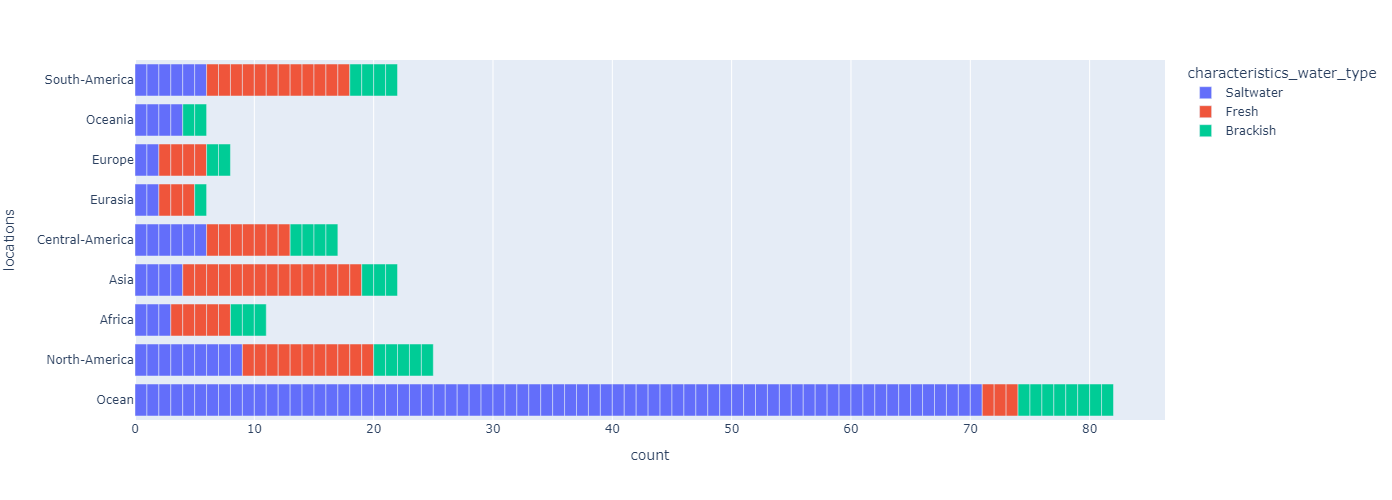

In [331]:
# Filtrar los valores "Unknown, NotListed = la especie no ha sido evaluada, LeastConcern = preocupacion menor, DataDeficient = no hay datos suficientes
# cambiar el tipo de agua Salt por Saltwater, ya que se refieren a agua salada"
df_filtrado1 = df_ocean.query('characteristics_water_type != "Unknown" and characteristics_water_type.notna() and locations != "NotListed" and locations != "LeastConcern" and locations != "DataDeficient" and locations != "Unknown"')
df_filtrado1["characteristics_water_type"] = df_filtrado1["characteristics_water_type"].replace("Salt", "Saltwater")
# Definir el tamaño de la figura
fig = px.bar(data_frame=df_filtrado1,
             y="locations",
             hover_data=["characteristics_habitat", "name", "taxonomy_family"],
             color="characteristics_water_type",
             height=500,  # Ajusta el alto de la figura
             width=800)   # Ajusta el ancho de la figura

# Mostrar el gráfico
fig.show()

**CONCLUSION**
En conclusión, observamos que la mayoría de las especies marinas se encuentran en los océanos. Aunque no se especifica en cuál de los cinco océanos, es evidente que la gran mayoría de estas especies prosperan en ambientes de agua salada. Esto subraya la notable distinción entre las especies que habitan en los océanos y aquellas que prefieren agua dulce o se encuentran en ríos que desembocan en los mares. Las especies que habitan en ríos o en los cauces que desembocan en los mares tienden a concentrarse en los continentes, lo que contribuye significativamente a la biodiversidad de los ecosistemas terrestres.

In [332]:
df_filtrado2 = df_filtrado1.query('coordenadas != "Unknown" and coordenadas.notna()')

world_map = folium.Map(location=[0, 0], zoom_start=0)
ocean = folium.map.FeatureGroup()

coord_classes = {}

# Recorre las coordenadas y agrega a cada una al FeatureGroup() de animales
for coords, name, tipo in zip(df_filtrado2["coordenadas"], df_filtrado2["name"], df_filtrado2["characteristics_habitat"]):
    lat, lng = coords

    # Si la coordenada ya está en el diccionario, agrega la clase, de lo contrario, crea una nueva lista
    if (lat, lng) in coord_classes:
        coord_classes[(lat, lng)].append((name, tipo))  # Ahora coord_classes es una lista de tuplas
    else:
        coord_classes[(lat, lng)] = [(name, tipo)]

# Iterar sobre el diccionario y agregar marcadores al FeatureGroup
for coords, classes in coord_classes.items():
    lat, lng = coords
    popup_content = ""
    for name, tipo in classes:
        popup_content += "<b>Nombre:</b> {}<b>\tTipo:</b> {}<br><br>".format(name, tipo)
    popup = folium.Popup(popup_content, min_width = 300, max_width = 300)
    ocean.add_child(folium.CircleMarker(location     = [lat, lng],
                                          radius       = 9,
                                          color        = "blue",
                                          fill         = True,
                                          fill_color   = "green",
                                          fill_opacity = 0.6,
                                          popup        = popup))

world_map.add_child(ocean)

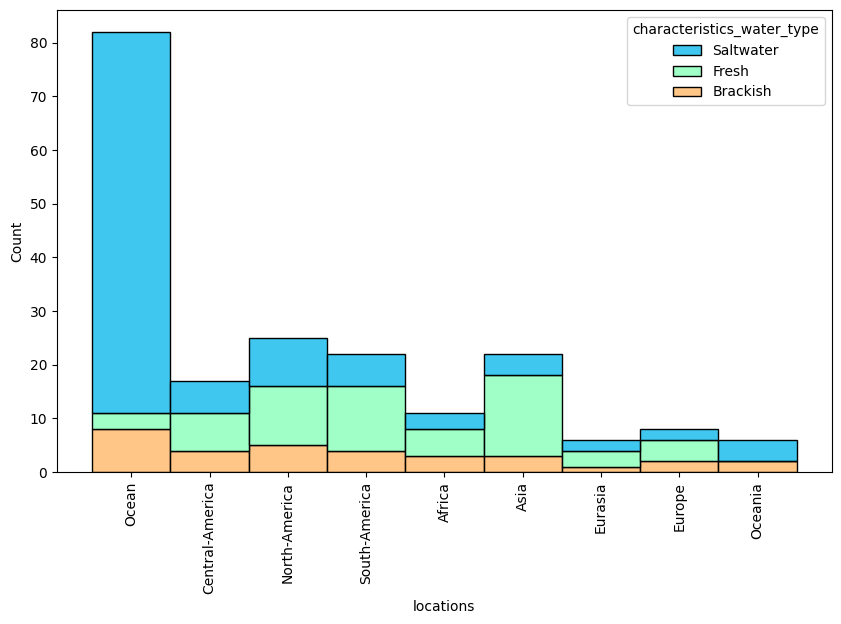

In [333]:
plt.figure(figsize = (10, 6))

sns.histplot(
    x       = "locations", 
    hue     = "characteristics_water_type", 
    data    = df_filtrado1,
    palette = "rainbow",
    multiple = 'stack')

plt.xticks(rotation=90)

plt.show()

**2. Comparación de Tamaño y Peso**:
   - Columnas necesarias: `peso_en_kg`, `longitud_cm`.
   - Gráfico: Un gráfico de dispersión para visualizar la relación entre el peso y el tamaño.

In [334]:
df_ocean.rename(columns={'altura_cm': 'longitud_cm'}, inplace=True)
df_ocean["longitud_cm"] = pd.to_numeric(df_ocean["longitud_cm"], errors='coerce')
df_ocean["peso_en_kg"] = pd.to_numeric(df_ocean["peso_en_kg"], errors='coerce')

In [346]:
filtrado3 = df_ocean[df_ocean["peso_en_kg"].notna() & df_ocean["longitud_cm"].notna() & (df_ocean["peso_en_kg"] != "Unknown") & (df_ocean["longitud_cm"] != "Unknown")]

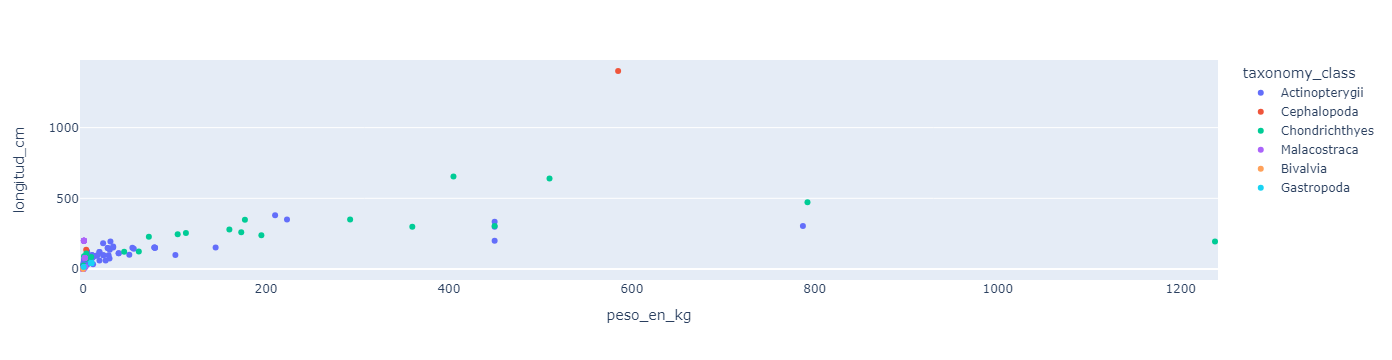

In [347]:
fig = px.strip(data_frame = filtrado3,
        x          = "peso_en_kg",
        y          = "longitud_cm",
        color      = "taxonomy_class",
        hover_name      = "name",
        hover_data = ["locations", "characteristics_habitat", "characteristics_water_type"])
fig.show()

**CONCLUSIÓN** La observación detallada de las especies acuáticas revela una amplia variabilidad en términos de peso y altura. Desde especies relativamente pequeñas hasta otras notoriamente grandes, se aprecia una diversidad notable. Entre las especies más pesadas, se destacan Beluga Sturgeon, Colossal Squid, Megamouth Shark, Shark, todos pertenecientes a la clase Actinopterygii, que engloba a la mayoría de las especies de peces conocidos por sus aletas radiadas, Cephalopoda, y Chondrichthyes. Por otro lado, entre las especies más grandes se encuentran Colossal Squid, Greenland Shark, Megamouth Shark, Sawfish. Esta variabilidad evidencia adaptaciones específicas a los distintos entornos y modos de vida de estas especies acuáticas. El dato de la especie más grande que tenemos es Colossal Squid, ya que del Megalodon no sabemos la longitud exacta.

In [362]:
filtrado4 = df_ocean[(df_ocean["longitud_cm"] < 250) & (df_ocean["peso_en_kg"] < 40) & df_ocean["peso_en_kg"].notna() & df_ocean["longitud_cm"].notna()]

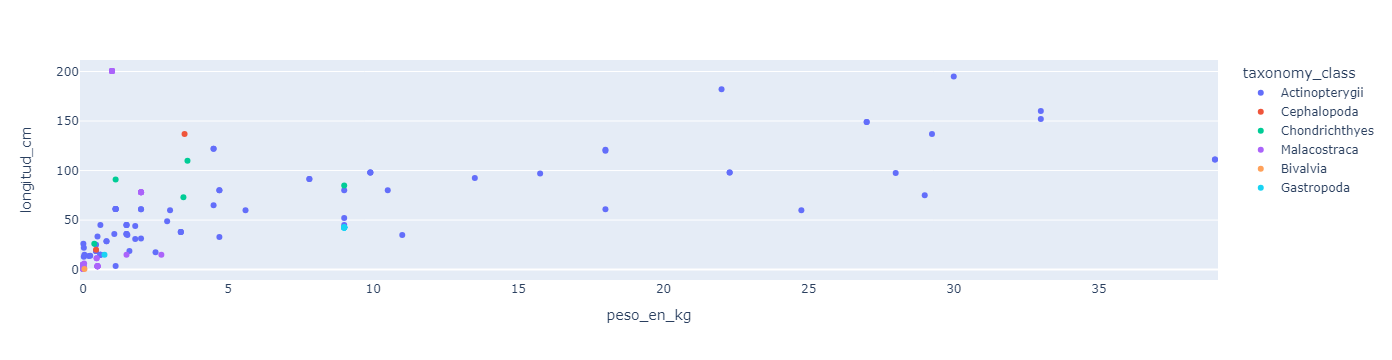

In [363]:
fig = px.strip(data_frame = filtrado4,
        x          = "peso_en_kg",
        y          = "longitud_cm",
        color      = "taxonomy_class",
        hover_name      = "name",
        hover_data = ["locations", "characteristics_habitat", "characteristics_water_type"])
fig.show()

**CONCLUSIÓN** La observación detallada de la siguiente gráfica revela que, a pesar de la presencia de especies pequeñas y livianas en la clase Actinopterygii, otras clases como Cephalopoda, Gastropoda, Malacostraca, Bibalvia y Chondrichthyes albergan especies aún más diminutas. En contraposición se destaca el caso del Blanket Octopus, que tiene una media de 1,40 m y pesa de media unos 3,5 kg y el Crab, con 2 m y 1 kg, siendo el animal que más mide a la vez que menos pesa, esto se debe a la envergadura de sus patas, ya que su cuerpo alcanza unos 40 cm. Esta variabilidad en tamaño y peso entre las distintas clases refleja una adaptación diversificada a sus respectivos entornos y modos de vida.

In [364]:
filtrado5 = df_ocean[(df_ocean["peso_en_kg"].notna()) & (df_ocean["longitud_cm"].notna()) & (df_ocean["taxonomy_class"] == "Actinopterygii")]

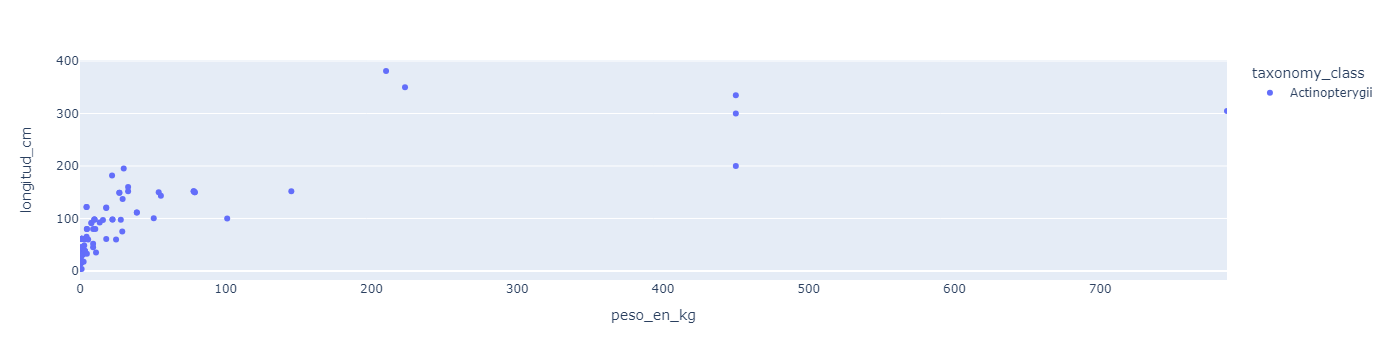

In [366]:
fig = px.strip(data_frame = filtrado5,
        x          = "peso_en_kg",
        y          = "longitud_cm",
        color      = "taxonomy_class",
        hover_name      = "name",
        hover_data = ["locations", "characteristics_habitat", "characteristics_water_type"])
fig.show()

**CONCLUSIÓN** La variabilidad observada en la clase Actinopterygii en términos de altura y peso sugiere una amplia diversidad morfológica dentro de este grupo de peces con aletas radiadas. Esta heterogeneidad en características físicas como la altura y el peso puede estar relacionada con una adaptación a diferentes hábitats y modos de vida dentro de esta clase taxonómica.

**3. Comportamiento Grupal vs. Hábitats**:
   - Columnas necesarias: `characteristics_group_behavior`, `characteristics_habitat`.
   - Gráfico: Un gráfico de barras apiladas para mostrar cómo varía el comportamiento grupal en diferentes hábitats.

In [453]:
lista_comportamientos = ['School', 'Solitary', 'Social', 'Unknown', 'Solitary/Group',
       'Territorial', 'Solitary/School', 'Largely solitary',
       'SolitarySchool', 'Colony', 'SolitaryTerritorial', 'Gregarious',
       'SolitaryGroup', 'Swarm', 'Pod', 'Mainly solitary', 'Legion',
       'Group', 'Pack', 'Solitary/Pairs', 'Beds (like reefs)']

lista_traducciones = ['Escuela', 'Solitario', 'Social', 'Desconocido', 'Solitario/Grupo', 'Territorial', 'Solitario/Escuela', 'Principalmente solitario', 'Solitario/Escuela', 'Colonia', 'Solitario/Territorial', 'Gregario', 'Solitario/Grupo', 'Enjambre', 'Manada', 'Mayormente solitario', 'Legión', 'Grupo', 'Manada', 'Solitario/Parejas', 'Lechos (como arrecifes)']

diccionario_traducciones = {}
for i, a in zip(lista_comportamientos, lista_traducciones):
    diccionario_traducciones[i] = a

df_ocean['comportamientos'] = df_ocean['characteristics_group_behavior'].map(diccionario_traducciones)

def agrupar_comportamiento(comportamiento):
    if "solitario" in comportamiento.lower():
        return "Solitario"
    elif "escuela" in comportamiento.lower():
        return "Escuela"
    elif "social" in comportamiento.lower():
        return "Social"
    elif "territorial" in comportamiento.lower():
        return "Territorial"
    elif "colonia" in comportamiento.lower():
        return "Colonia"
    elif "manada" in comportamiento.lower():
        return "Manada"
    elif "lechos" in comportamiento.lower():
        return "Lechos"
    elif "enjambre" in comportamiento.lower():
        return "Enjambre"
    elif "gregario" in comportamiento.lower():
        return "Gragario"
    else:
        return "Desconocido"
    
df_ocean["comportamientos"] = df_ocean['comportamientos'].apply(agrupar_comportamiento)

In [406]:
def agrupar_habitat(habitat):
    if 'ocean' in habitat.lower() or 'sea' in habitat.lower() or 'saltwater' in habitat.lower() or 'brackish water' in habitat.lower():
        return 'Hábitat Marino'
    elif 'river' in habitat.lower() or 'lake' in habitat.lower() or 'freshwater' in habitat.lower() or 'stream' in habitat.lower() or 'lagoon' in habitat.lower():
        return 'Hábitat de Agua Dulce'
    elif 'reef' in habitat.lower() or 'coast' in habitat.lower() or 'shore' in habitat.lower() or 'coral' in habitat.lower():
        return 'Hábitat de Arrecifes'
    elif 'tropical' in habitat.lower() or "tropics" in habitat.lower():
        return "Hábitat Tropicales"
    elif "forest" in habitat.lower() or "woods" in habitat.lower() or "gardens" in habitat.lower() or "vegetated" in habitat.lower():
        return "Hábita Forestal"
    elif "rock" in habitat.lower() or "rocks" in habitat.lower() or "rocky" in habitat.lower():
        return "Hábitat Rocoso"
    else:
        return 'Otro Hábitat'

df_ocean['habitat'] = df_ocean['characteristics_habitat'].apply(agrupar_habitat)

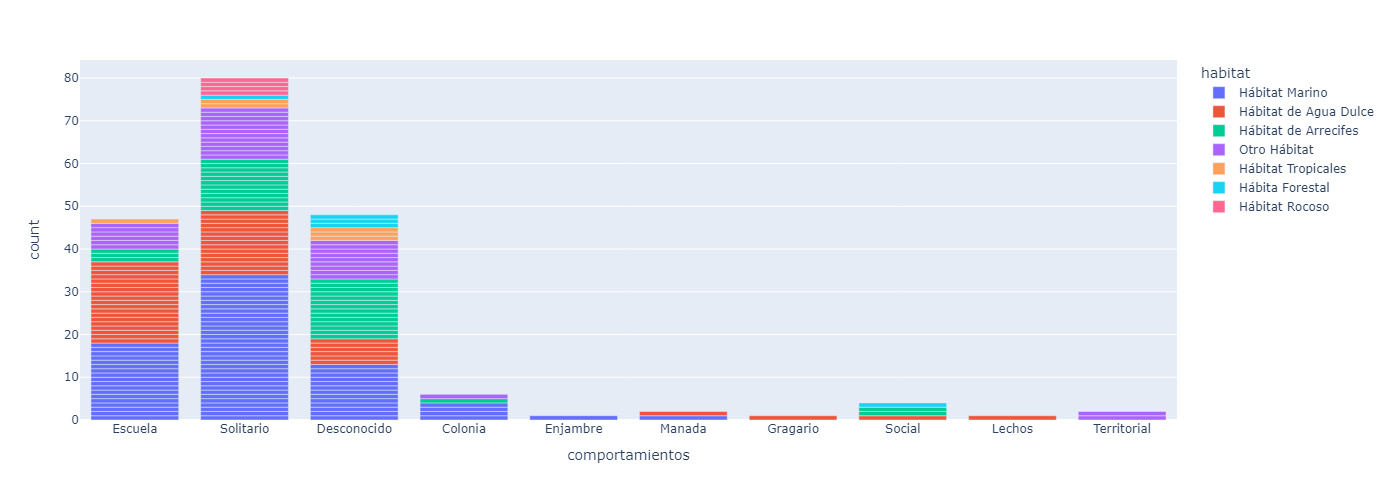

In [455]:
fig = px.bar(data_frame=df_ocean.drop_duplicates(subset="name"),
             x = "comportamientos",
             hover_data=["name", "taxonomy_class"],
             color="habitat",
             height=500,  # Ajusta el alto de la figura
             width=800)   # Ajusta el ancho de la figura

# Mostrar el gráfico
fig.show()

**CONCLUSIÓN** En resumen, el análisis de los datos revela patrones de comportamiento prominentes en el conjunto de datos. Los comportamientos de "Escuela" y "Solitario" destacan como los más comunes, mostrando una clara asociación con distintos tipos de hábitats. Mientras que "Solitario" predomina en entornos marinos, "Escuela" es más prevalente en hábitats de agua dulce. Los comportamientos menos comunes sugieren una mayor especialización, posiblemente adaptada a entornos específicos. La variabilidad en la distribución de comportamientos indica posibles adaptaciones a condiciones ambientales particulares. Esta fuerte asociación entre comportamientos y hábitats plantea la posibilidad de una correlación o adaptación específica a entornos. Este hallazgo promete ser un punto focal para investigaciones futuras, ofreciendo oportunidades para explorar en mayor profundidad las causas y consecuencias de estas relaciones en el contexto de este conjunto de datos. Veremos ahora como se comporta cada clase:

LA MISMA GRÁFICA PERO PARA EL POWERPOINT

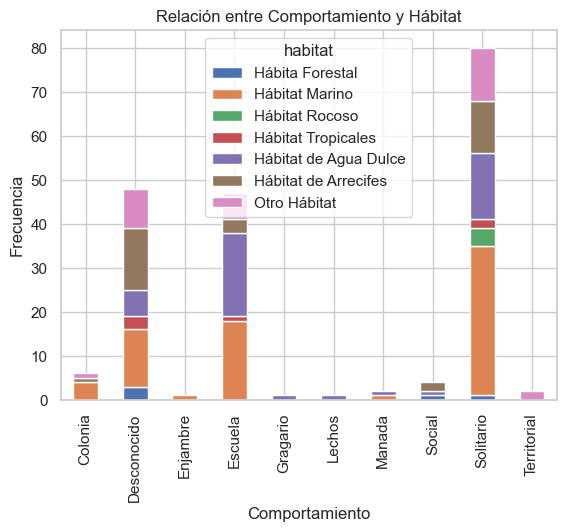

In [459]:
df_filtrado6 = df_ocean.drop_duplicates(subset="name")
# mostrará las frecuencias de cada combinación de comportamiento y hábitat
df_grouped = df_filtrado6.groupby(['comportamientos', 'habitat']).size().unstack(fill_value=0)

ax = df_grouped.plot(kind='bar', stacked=True)

plt.xlabel('Comportamiento')
plt.ylabel('Frecuencia')
plt.title('Relación entre Comportamiento y Hábitat')

plt.show()

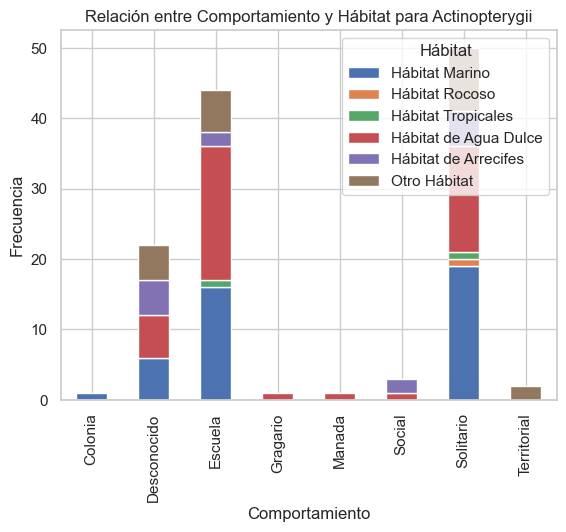

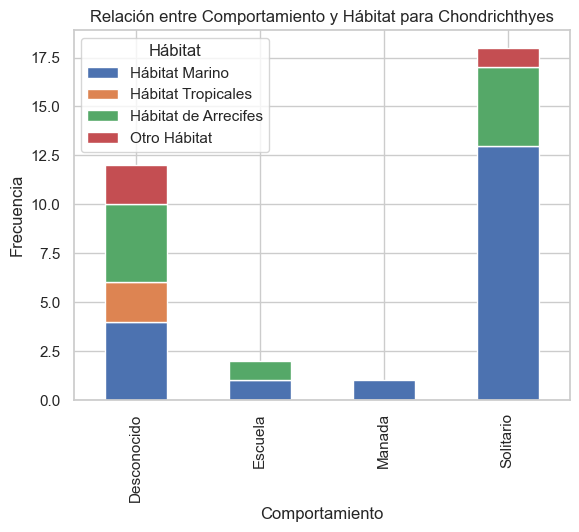

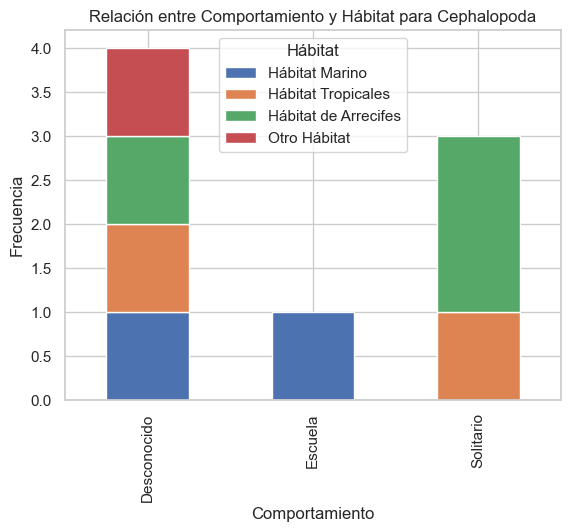

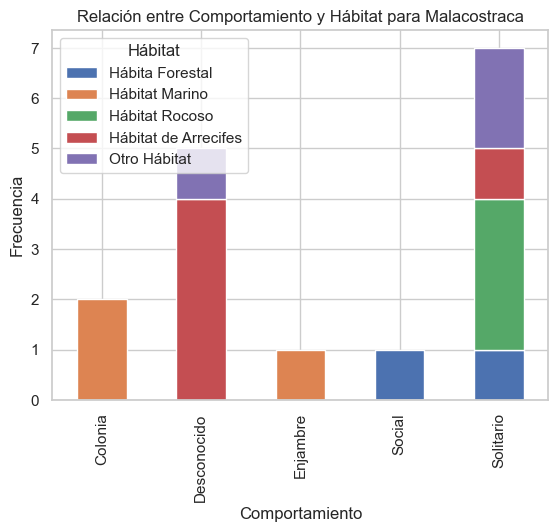

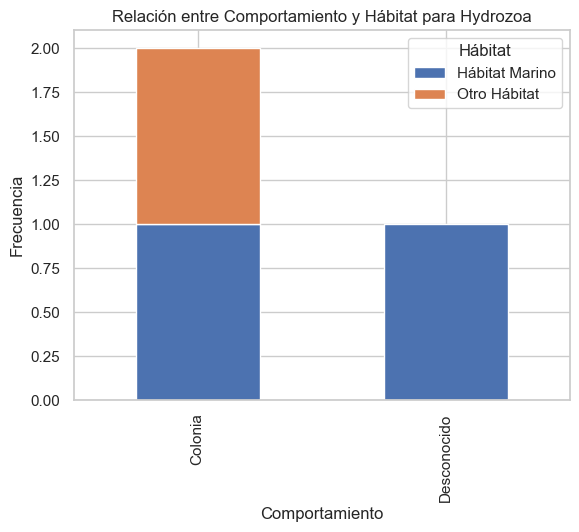

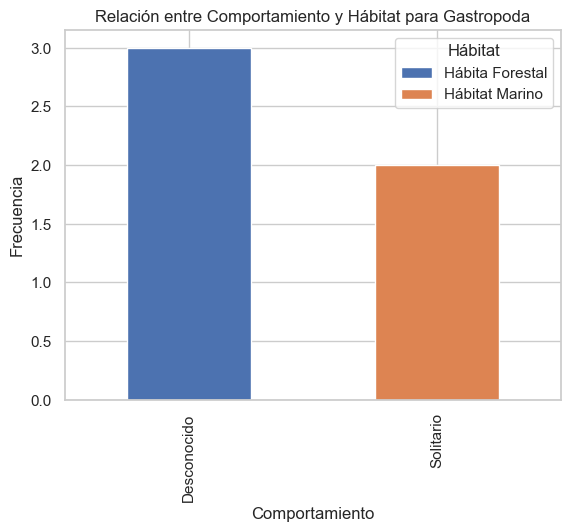

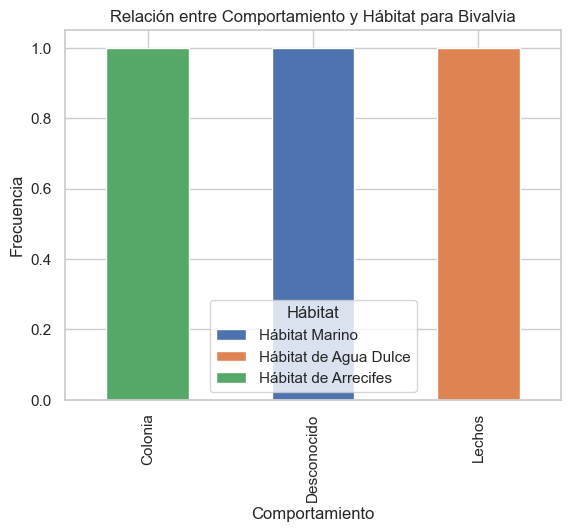

In [460]:
clases_taxonomicas = df_ocean["taxonomy_class"].unique()

for clase_taxonomica in clases_taxonomicas:
    df_filtrado7 = df_ocean[(df_ocean["taxonomy_class"] == clase_taxonomica)].drop_duplicates(subset= "name")
    
    df_agrupado = df_filtrado7.groupby(['comportamientos', 'habitat']).size().unstack(fill_value=0)

    ax = df_agrupado.plot(kind='bar', stacked=True)

    plt.xlabel('Comportamiento')
    plt.ylabel('Frecuencia')
    plt.title(f'Relación entre Comportamiento y Hábitat para {clase_taxonomica}')
    plt.legend(title='Hábitat')

    plt.show()

**4. Distribución de Especies por Color y Tipo de Alimentación**:
   - Columnas necesarias: `characteristics_color`, `characteristics_diet`.
   - Gráfico: Un gráfico de dispersión o un gráfico de burbujas para visualizar la distribución de especies según el color

In [485]:
def separar_colores(texto):
    colores = []
    color_actual = ""
    
    for letra in texto:
        if letra.isupper():
            if color_actual:
                colores.append(color_actual)
            color_actual = letra
        else:
            color_actual += letra
    
    if color_actual:
        colores.append(color_actual)
    
    return colores

In [486]:
df_ocean['colores'] = df_ocean['characteristics_color'].apply(separar_colores)
df_ocean['colores'] = df_ocean['colores'].astype(str)
df_ocean = df_ocean.assign(colores=df_ocean['colores'].str.split(',')).explode('colores')
# Reemplazar los corchetes por una cadena vacía
df_ocean['colores'] = df_ocean['colores'].str.replace('[', '').str.replace(']', '').str.replace("'", '')
df_ocean['colores'] = df_ocean['colores'].str.replace(' ', '')
df_ocean["colores"] = df_ocean["colores"].replace("-", "")
df_ocean.reset_index(drop=True, inplace=True)

C:\Users\Ane Zubieta\AppData\Local\Temp\ipykernel_17516\970091751.py:5: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



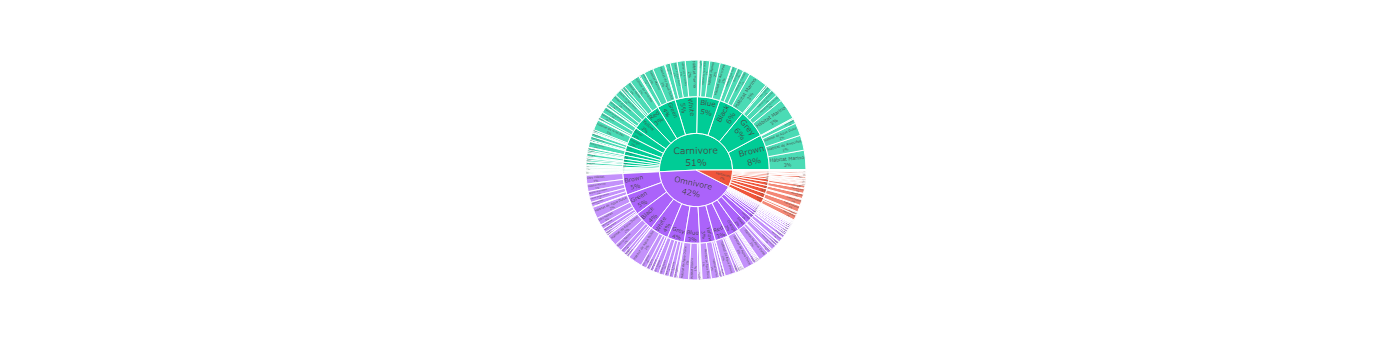

In [527]:
fig = px.sunburst(data_frame=df_ocean,
                  path=['characteristics_diet', "colores", "habitat"], # Aquí especificas el orden y jerarquía de las categorías
                  color='characteristics_diet',
                  hover_name = "habitat")           # Color basado en la categoría de colores

fig.update_traces(textinfo='label+percent entry')  # Puedes ajustar la información que se muestra en el hover

fig.show()

**CONCLUSIÓN:** La clase Actinopterygii, Malacostraca tiene un comportamiento variado en habitats distintas, mientras que clases como Gatropoda e Hydrozoa solo tenemos constancia de un comportamiento, solitario y colonial respectivamente.

2.MICROORGANISMOS:

**Distribución de Microorganismos por Reino**:
   - Columnas necesarias: `taxonomy_kingdom`
   - Gráfico eficaz: Gráfico de barras o gráfico circular para mostrar la distribución de microorganismos en cada reino.

**Frecuencia de Microorganismos por Filo (Phylum)**:
   - Columnas necesarias: `taxonomy_phylum`
   - Gráfico eficaz: Gráfico de barras para mostrar la frecuencia de microorganismos en cada filo.

**Clasificación Taxonómica de Microorganismos**:
   - Columnas necesarias: `taxonomy_class`, `taxonomy_order`, `taxonomy_family`, `taxonomy_genus`, `taxonomy_scientific_name`
   - Gráfico eficaz: Un gráfico de barras apiladas o un gráfico de dispersión que muestre la clasificación taxonómica de los microorganismos.

**Hábitats Preferidos de Microorganismos**:
   - Columnas necesarias: `characteristics_habitat`
   - Gráfico eficaz: Un gráfico de barras para mostrar los hábitats más comunes de los microorganismos.

In [ ]:
df_microorganismos = pd.read_csv("Microorganismos_air.csv")

In [ ]:
for columna in df_microorganismos.columns:
    # Verificamos si la columna contiene la cadena "unknown"
    if df_microorganismos[columna].str.contains('Unknown').any():
        # Si la contiene, eliminamos la columna del nuevo DataFrame
        df_microorganismos.drop(columna, axis=1, inplace=True)
        
df_microorganismos.drop('characteristics_number_of_species', axis=1, inplace=True)

3. REPTILES:

**Distribución de Hábitats por Taxonomía**:
   - Columnas necesarias: `characteristics_habitat`, `taxonomy_order` (o cualquier otra columna de taxonomía).
   - Gráfico: Un gráfico de barras apiladas para mostrar cómo se distribuyen los hábitats en diferentes órdenes (o cualquier otro nivel taxonómico).

**Comparación de Tamaño y Peso**:
   - Columnas necesarias: `characteristics_weight`, `characteristics_length`.
   - Gráfico: Un gráfico de dispersión para visualizar la relación entre el peso y el tamaño.

**Comportamiento Grupal vs. Hábitats**:
   - Columnas necesarias: `characteristics_group_behavior`, `characteristics_habitat`.
   - Gráfico: Un gráfico de barras apiladas para mostrar cómo varía el comportamiento grupal en diferentes hábitats.

**Distribución de Especies por Color y Tipo de Alimentación**:
   - Columnas necesarias: `characteristics_color`, `characteristics_diet`.
   - Gráfico: Un gráfico de dispersión o un gráfico de burbujas para visualizar la distribución de especies según el color y la dieta.

In [91]:
df_reptiles = pd.read_csv("Reptiles_air.csv")

In [89]:
#df_reptiles["peso_en_kg"]=df_reptiles["characteristics_weight"].apply(lambda x: convertirpesos(x))
#df_reptiles["altura_cm"]=df_reptiles["characteristics_lenght"].apply(lambda x: convertiralturas(x))
#df_reptiles.to_csv("Reptiles_air.csv", index = False)

4. ANFIBIOS

In [117]:
df_anfibios = pd.read_csv("Anfibios_air.csv")

In [69]:
#df_anfibios["peso_en_kg"]=df_anfibios["characteristics_weight"].apply(lambda x: convertirpesos(x))
#df_anfibios["altura_cm"]=df_anfibios["characteristics_lenght"].apply(lambda x: convertiralturas(x))
#df_anfibios.to_csv("Anfibios_air.csv", index = False)

**1 - DISTRIBUCIÓN DE ANFIBIOS SEGÚN SU ORDEN TAXONÓMICO:**

**Los anfibios pertenecen a la clase Amphibia, que se divide en tres órdenes:**
**- Urodela:**
- Salamandras modernas
**- Anuros:**
- Ranas y sapos.
**- Caudados:** 
- Incluye a las salamandra y los tritones.
- Los caracteres derivados compartidos de Caudata son la presencia de una cola desarrollada, la longitud similar de todas sus extremidades, la presencia de branquias en las larvas acuáticas, la presencia de dientes en ambas mandíbulas, la ausencia de orejas timpánicas y la presencia de costillas
**- Gymnophiona:**
- Anfibios excavadores sin extremidades.
**- Hylidae:**
- Ranas arborícolas comunes.
**- Mesobatrachia:**
- Mesobatrachia es un grupo nuevo, recién identificado en 1993.

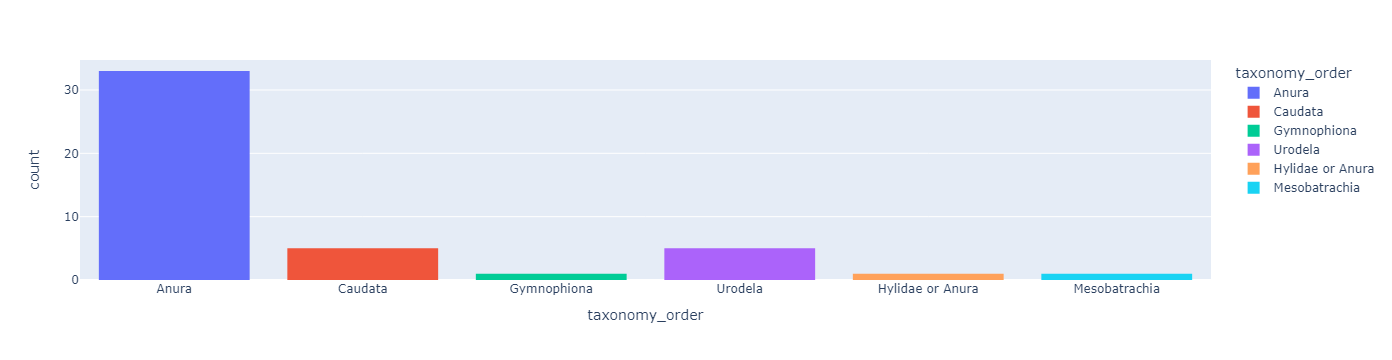

In [118]:
px.histogram(data_frame = df_anfibios,
             x          = df_anfibios['taxonomy_order'],
             hover_data =  df_anfibios,
             color      = df_anfibios['taxonomy_order'],
             nbins      = 200)

El análisis del gráfico destaca una marcada disparidad en la cantidad de registros de cada especie en nuestra base de datos. "Anura" se posiciona como la especie más frecuente, con un total de 33 registros, seguida por Caudata y Urodela, ambas con 5 registros cada una. Por otro lado, las demás especies muestran una presencia mucho más limitada, con solo 1 registro cada una.

Esta disparidad en la distribución de datos señala la necesidad de equilibrar la representación de especies en la base de datos para garantizar una visión más completa y precisa de la diversidad biológica. Priorizar investigaciones o acciones centradas en especies con menor representación puede ser fundamental para enriquecer la información y promover un enfoque más inclusivo en futuros estudios.

**2 - CARACTERÍSTICAS POPULACIONALES VS. AMENAZAS PRINCIPALES:**

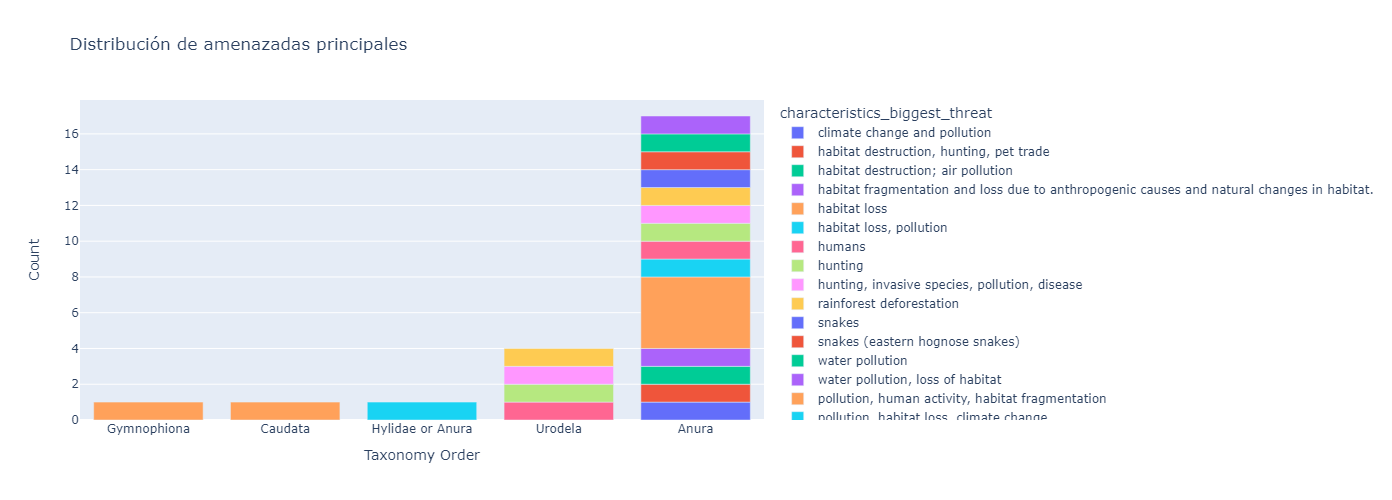

In [119]:
# 1º vamos a ignorar los "unknown"
data_sin_nulos = df_anfibios[df_anfibios['characteristics_biggest_threat'] != 'Unknown'] 

# Ponemos todos los valores en minúscula para que se contabilicen correctamente
data_sin_nulos['characteristics_biggest_threat'] = data_sin_nulos['characteristics_biggest_threat'].str.lower()


# 3º Vamos a agrupar el data sin nulos cogiendo las columnas que nos interesan, añadiendo la columna "count" según se cuenten las amenazas según el orden
df_agrupado = data_sin_nulos.groupby(['taxonomy_order', 'characteristics_biggest_threat']).size().reset_index(name='count')


# Gráfico de barras agrupadas
fig = px.bar(df_agrupado, x='taxonomy_order', y='count', color='characteristics_biggest_threat',
             title='Distribución de amenazadas principales', labels={'count': 'Count'}, height=500,  # Ajusta el alto de la figura
             width=800)
#Personalización
fig.update_layout(xaxis_title='Taxonomy Order', yaxis_title='Count')
fig.update_xaxes(categoryorder='total ascending')

# Muestra el gráfico
fig.show()

**CONCLUSIÓN** En este análisis detallado de las amenazas que afectan a las órdenes de la clase "Anfibios", se han identificado patrones significativos que requieren nuestra atención.

1. La orden "Anura" se encuentra en una situación especialmente preocupante, ya que enfrenta una serie de amenazas, con la pérdida de hábitat como el factor más predominante. Esto subraya la urgente necesidad de medidas de conservación dirigidas a preservar y restaurar los espacios vitales de esta orden.

2. Para la orden "Urodela", las amenazas son diversas y varían desde la presencia del hongo "Bsal" hasta la contaminación ambiental. La sobreexplotación de recursos y la degradación del hábitat también contribuyen a sus desafíos. Es esencial implementar estrategias para abordar estas amenazas específicas.

3. La orden "Hylidae" se ve afectada por múltiples factores, incluyendo la contaminación, la pérdida de hábitat y el cambio climático. Estas amenazas están ejerciendo una presión significativa en su capacidad para sobrevivir y prosperar en su entorno natural.

**3 - DISTRIBUCIÓN DE HÁBITATS**

C:\Users\Ane Zubieta\AppData\Local\Temp\ipykernel_17516\737507062.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Ane Zubieta\AppData\Local\Temp\ipykernel_17516\737507062.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



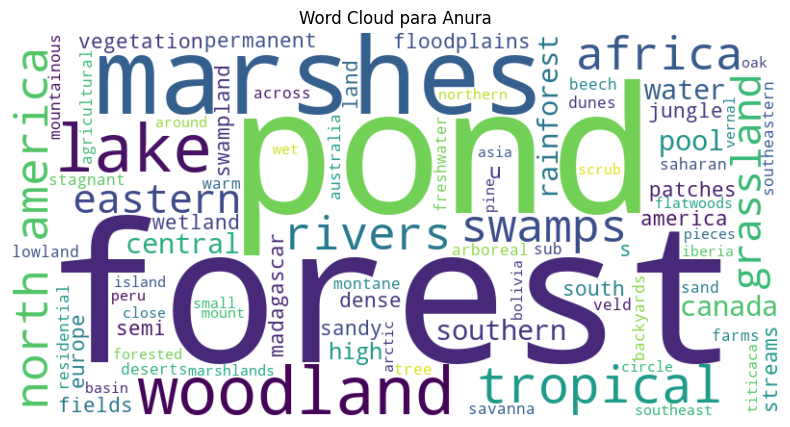

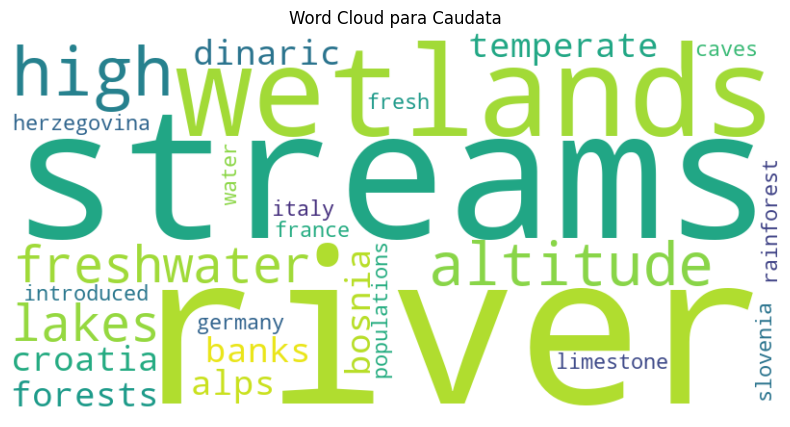

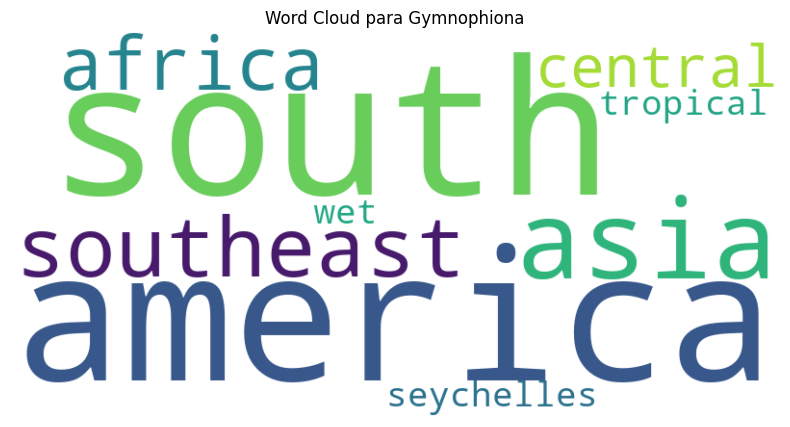

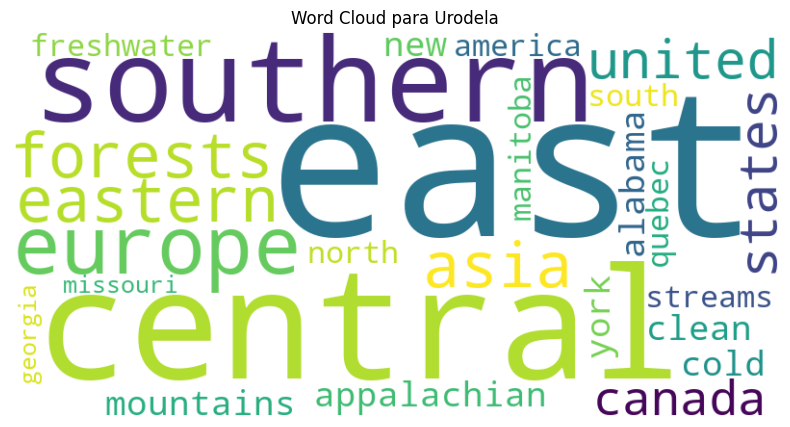

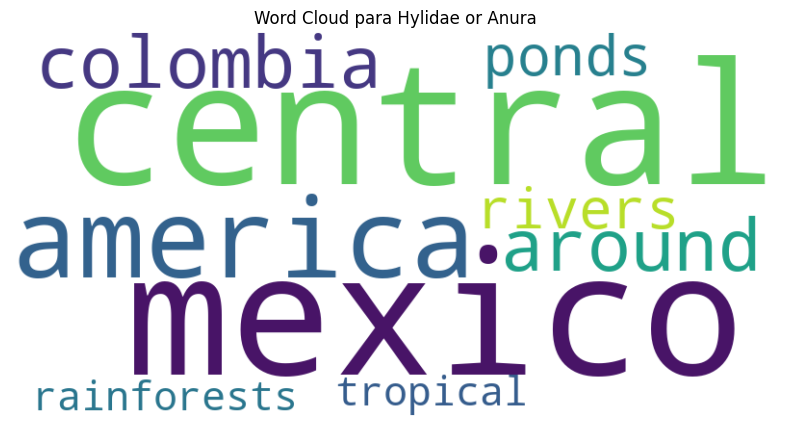

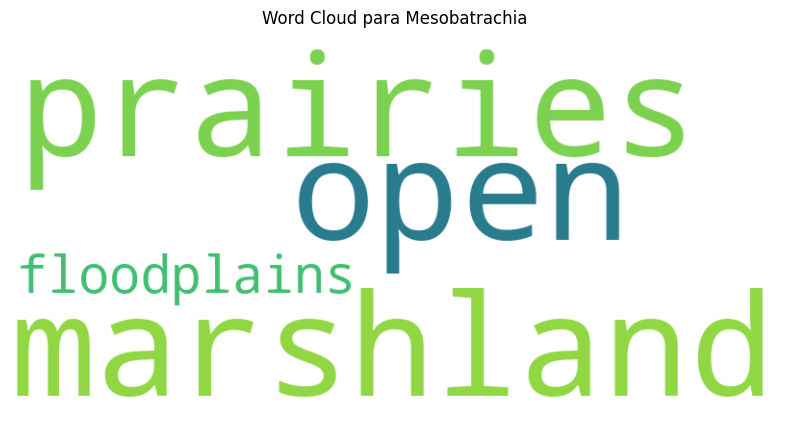

In [96]:
# Tokenización y procesamiento de texto
text_columns = ['characteristics_location', 'characteristics_habitat']

for column in text_columns:
    df_anfibios[column] = df_anfibios[column].str.lower()

# Crear un word cloud para cada orden de taxonomía
taxonomy_orders = df_anfibios['taxonomy_order'].unique()

for order in taxonomy_orders:
    order_data = df_anfibios[df_anfibios['taxonomy_order'] == order]
    order_data['characteristics_location'].fillna('', inplace=True)
    order_data['characteristics_habitat'].fillna('', inplace=True)
    text = ' '.join(order_data['characteristics_location'] + " " + order_data['characteristics_habitat'])
    text = ' '.join(word for word in text.split() if word != 'unknown')
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud para {order}')
    plt.axis("off")
    plt.show()

**CONCLUSIONES**
El análisis del treemap proporciona valiosa información sobre las preferencias y distribuciones de hábitat de cada orden de anfibios. Esto es esencial para comprender y conservar adecuadamente estas especies en su entorno natural:
1. **Urodela**
   - La ubicación geográfica destacada sugiere una asociación fuerte con América del Norte y del Este.
   - Se identificaron focos geográficos más específicos, como Quebec y Manitoba, indicando una distribución diversa.
   - Las características del hábitat señalan preferencia por entornos con agua dulce, montañas, bosques y climas fríos.
2. **Anura**
   - La prevalencia de hábitats acuáticos, como estanques y bosques, es evidente.
   - Se destaca la versatilidad en una variedad de entornos, incluyendo pantanos y regiones tropicales.
   - Las palabras clave sugieren una distribución geográfica amplia y adaptabilidad a diversos hábitats.
3. **Caudata**
   - Hábitats acuáticos, como arroyos y humedales, son predominantes.
   - También se señala una adaptación a regiones montañosas de gran altitud.
   - La distribución geográfica parece centrarse en Europa, especialmente en áreas montañosas.
4. **Gymnophiona**
   - Una fuerte asociación con América del Sur es evidente, con menciones a otras regiones como Asia, África y América Central.
   - Se destacan características de hábitat húmedo y tropical, con una mención específica a Seychelles.
5. **Hylidae**
   - América Central y México son las ubicaciones principales, con una presencia destacada en toda América.
   - Se identifican ubicaciones específicas como Colombia, respaldando la diversidad geográfica.
   - La preferencia por hábitats tropicales, bosques lluviosos y estanques es evidente.
6. **Mesobatrachia**
   - Asociación fuerte con hábitats como marismas, praderas y áreas abiertas es destacada.
   - La disponibilidad de alimento en hábitats como foodplains es un factor importante.

**4 - RELACIÓN ENTRE TAMAÑO Y PESO:**

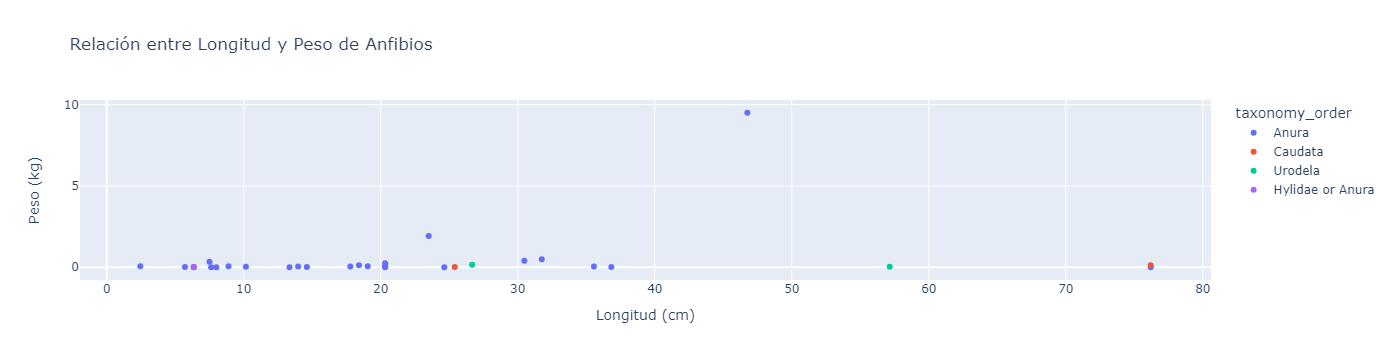

In [120]:
#Convierto las columnas de longitud y peso en floats para poder representarlas
df_anfibios['altura_cm'] = pd.to_numeric(df_anfibios['altura_cm'], errors='coerce')
df_anfibios['altura_cm'] = df_anfibios['altura_cm'].fillna(0).astype(float)
df_anfibios.rename(columns={'altura_cm': 'longitud_cm'}, inplace=True)


df_anfibios['peso_en_kg'] = pd.to_numeric(df_anfibios['peso_en_kg'], errors='coerce')
df_anfibios['peso_en_kg'] = df_anfibios['peso_en_kg'].fillna(0).astype(float)

# Crear un gráfico de dispersión con Plotly
fig = px.scatter(df_anfibios[(df_anfibios['longitud_cm'] != 0) & (df_anfibios['peso_en_kg'] != 0)],
                  x ='longitud_cm',
                  y ='peso_en_kg',
                  color = 'taxonomy_order',
                  hover_name = "name",
                  title ='Relación entre Longitud y Peso de Anfibios')

# Personalizar el gráfico
fig.update_layout(xaxis_title='Longitud (cm)', yaxis_title='Peso (kg)')

# Mostrar el gráfico interactivo
fig.show()

**CONCLUSIÓN** En nuestra exploración detallada de la muestra de anfibios, hemos observado una tendencia general en cuanto a su rango de peso y longitud, con la mayoría de las especies oscilando entre 10 y 200 gramos de peso, y presentando longitudes que varían entre 2,45 y 30 centímetros. No obstante, al analizar a fondo los datos, nos hemos percatado de valores destacados que llaman la atención.

Por ejemplo, el "African Bullfrog" dentro del orden Anura sobresale con un peso excepcional de 9 kilogramos y una longitud de 46,76 centímetros. De manera similar, el "Fire salamander" en la categoría Urodela presenta una longitud inusual de 57,15 centímetros y un peso de 40 gramos. Además, el "Axoloti" en la clasificación Caudata sorprende con una longitud de 76,2 centímetros y un peso de 130 gramos.

En resumen, a pesar de la agrupación general en la gráfica según la taxonomía de orden, la variabilidad significativa en tamaño y peso que hemos observado en ciertas especies nos indica que la clasificación taxonómica por sí sola no puede explicar completamente estas diferencias. Esto sugiere la influencia de otros factores en las características físicas de estos anfibios, lo que resalta la complejidad y diversidad inherente a este grupo de organismos.

**5 - Relación entre el orden taxonómico y el comportamiento de grupo**

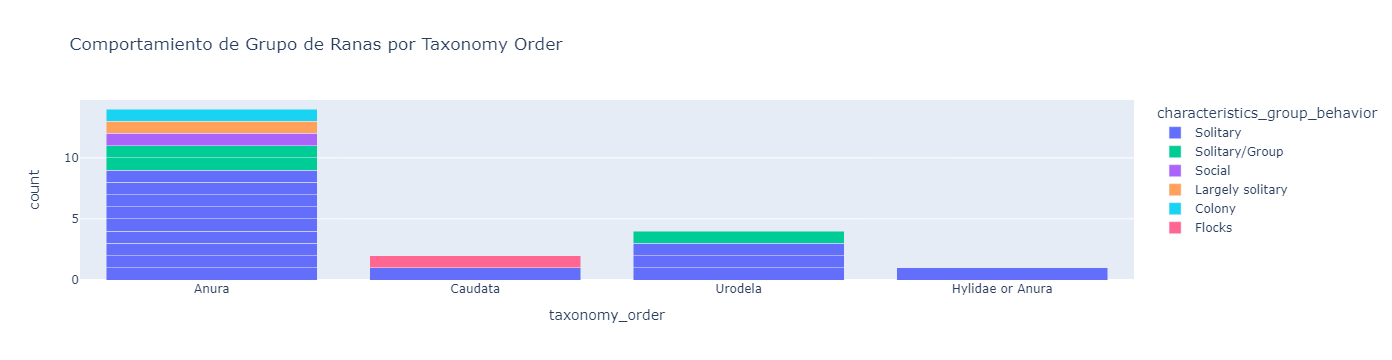

In [121]:
df_filtrado = df_anfibios[df_anfibios["characteristics_group_behavior"] != "Unknown"]

# Crea un gráfico de barras apiladas con Plotly
fig = px.bar(df_filtrado, x="taxonomy_order", color="characteristics_group_behavior", hover_name="name", title="Comportamiento de Grupo de Ranas por Taxonomy Order")
fig.update_layout(barmode="stack")
fig.show()

**CONCLUSIÓN** En nuestra investigación, hemos observado que la mayoría de los anfibios, independientemente de su clasificación taxonómica, exhiben tendencias hacia comportamientos solitarios. Sin embargo, hemos identificado notables excepciones en nuestro estudio. El "Mudpuppy" (Urodela) se distingue al mostrar un comportamiento gregario, prefiriendo moverse en grupos. Por otro lado, el "Green Tree Frog" (Anura) sobresale por su naturaleza sociable, mientras que el "Mantella Frog" (Anura) tiende a desplazarse en colonias. Estas diferencias en el comportamiento grupal aportan un fascinante matiz a la dinámica de los anfibios que hemos analizado. Esto subraya la diversidad de comportamientos que existe dentro de este grupo de organismos y nos invita a profundizar aún más en el estudio de sus interacciones sociales.

5. AVES:

**Distribución de Especies por Hábitat**:
   - Gráfico: Gráfico de barras
   - Columnas necesarias: 'characteristics_habitat', 'characteristics_number_of_species'
   - Librerías: Matplotlib o Seaborn

**Comparación de Peso y Longitud**:
   - Gráfico: Gráfico de dispersión
   - Columnas necesarias: 'characteristics_weight', 'characteristics_length'
   - Librerías: Matplotlib o Seaborn

**Distribución de Especies por Tipo de Alimentación**:
   - Gráfico: Gráfico de barras o pastel
   - Columnas necesarias: 'characteristics_diet', 'characteristics_number_of_species'
   - Librerías: Matplotlib o Seaborn

**Especies Venenosas vs. No Venenosas**:
   - Gráfico: Gráfico de barras o pastel
   - Columnas necesarias: 'characteristics_venomous', 'characteristics_number_of_species'
   - Librerías: Matplotlib o Seaborn

In [ ]:
df_aves = pd.read_csv("Aves_air.csv")

6. MAMIFEROS:

**Distribución de Hábitats**:
   - Columnas necesarias: `characteristics_habitat`.
   - Gráfico: Un gráfico de barras o un gráfico de tarta para mostrar la distribución de especies en diferentes hábitats.

**Comparación de Tamaño y Peso**:
   - Columnas necesarias: `characteristics_weight`, `characteristics_length`.
   - Gráfico: Un gráfico de dispersión para visualizar la relación entre el peso y el tamaño.

**Comportamiento Grupal vs. Hábitats**:
   - Columnas necesarias: `characteristics_group_behavior`, `characteristics_habitat`.
   - Gráfico: Un gráfico de barras apiladas para mostrar cómo varía el comportamiento grupal en diferentes hábitats.

**Distribución de Especies por Color y Tipo de Alimentación**:
   - Columnas necesarias: `characteristics_color`, `characteristics_diet`.
   - Gráfico: Un gráfico de dispersión o un gráfico de burbujas para visualizar la distribución de especies según el color y la dieta.

In [149]:
df_mamiferos = pd.read_csv("Mamifero_air.csv")

In [ ]:
#df_mamiferos["peso_en_kg"]=df_mamiferos["characteristics_weight"].apply(lambda x: convertirpesos(x))
#df_mamiferos["altura_cm"]=df_mamiferos["characteristics_lenght"].apply(lambda x: convertiralturas(x))

In [ ]:
df_mamiferos["peso_en_kg"]=df_mamiferos["characteristics_weight"].apply(lambda x: convertirpesos(x))
df_mamiferos["peso_en_kg"]=df_mamiferos["peso_en_kg"].apply(lambda x: np.nan if x==0.1234 else x) 

for a,i in zip(df_mamiferos["peso_en_kg"].to_list(),range(0,len(df_mamiferos["peso_en_kg"].to_list()))):
     if(type(a) == str):
        if((a.isnumeric()) and (int(a)== 000) or float(a)==0.000):
            print(df_mamiferos["name"].iloc[i])
            print(a,"cambia el peso")

            resul=float(input("introduce peso"))
            df_mamiferos["peso_en_kg"].iloc[i]=resul


        elif(a.isnumeric()):
            df_mamiferos["peso_en_kg"].iloc[i]=float(a)
            print(a," se ha cambiado por ",float(a))
        else:
            print("entra aqui por que ",a)

In [ ]:
for x,i in zip(df_mamiferos["altura_cm"].tolist(),range(0,len(df_mamiferos["altura_cm"].tolist()))):
    print(f'vamos por el indice {i}')
    try:
        resul=convertiraltura(x)
        df_mamiferos["altura_cm"].iloc[i]=resul
        print(resul)
    except:
        print(x,"no reconoce el valor meter uno por pantalla")
        valor=float(input("introduce el valor en cm"))
        df_mamiferos["altura_cm"].iloc[i]=valor

#df_mamiferos.to_csv("Mamifero_air.csv", index = False)

In [166]:
df_mamiferos["locations"].iloc[775]='Europe'
df_mamiferos["peso_en_kg"] = pd.to_numeric(df_mamiferos["peso_en_kg"], errors='coerce')

C:\Users\Ane Zubieta\AppData\Local\Temp\ipykernel_17516\3774384420.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



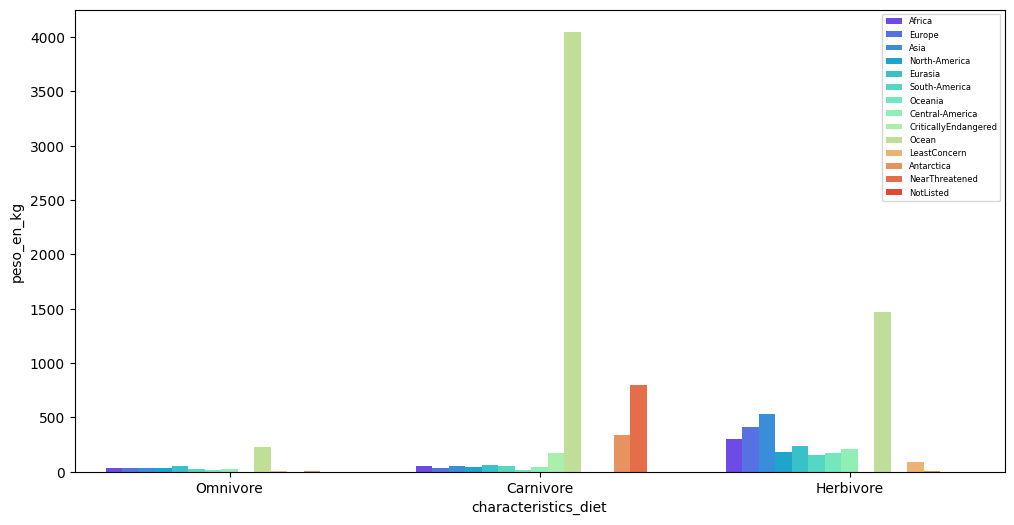

In [180]:
# Dividimos las celdas que contienen múltiples ubicaciones
df_mamiferos = df_mamiferos.assign(locations=df_mamiferos['locations'].str.split(',')).explode('locations')
# Reemplazar los corchetes por una cadena vacía
df_mamiferos['locations'] = df_mamiferos['locations'].str.replace('[', '').str.replace(']', '').str.replace("'", '')
df_mamiferos['locations'] = df_mamiferos['locations'].str.replace(' ', '')

plt.figure(figsize = (12, 6))

sns.barplot(x = "characteristics_diet", 
            y = "peso_en_kg", 
            hue = "locations", 
            data = df_mamiferos.reset_index(),
            errorbar=None,
            palette = "rainbow")
plt.legend(loc="center", bbox_to_anchor=(0.1, 1))
plt.legend(fontsize=6) 


plt.show()


In [181]:
df_mamiferos[(df_mamiferos["characteristics_diet"] == "Herbivore") & (df_mamiferos["peso_en_kg"] > 7000)]

,name,locations,taxonomy_kingdom,taxonomy_phylum,taxonomy_class,taxonomy_order,taxonomy_family,taxonomy_genus,taxonomy_scientific_name,characteristics_prey,...,characteristics_nesting_location,characteristics_favorite_food,characteristics_origin,characteristics_migratory,characteristics_special_features,domesticos,protegidos,exoticos,altura_cm,peso_en_kg
694,Steller’s Sea Cow,Ocean,Animalia,Chordata,Mammalia,Sirenia,Dugongidae,Hydrodamalis,Hydrodamalis Gigas,Unknown,...,Unknown,Sea Grasses,Unknown,Unknown,Unknown,1,0,0,8000.0,8000.0
775,Woolly Mammoth,Europe,Animalia,Chordata,Mammalia,Proboscidea,Elephantidae,Mammuthus,Mammuthus Primigenius,Unknown,...,Unknown,Grasses,Unknown,Unknown,Unknown,1,0,0,8000.0,8000.0


7. ANIMALES:

 **Distribución de las distintas clases por hábitat:**
   -Columnas necesarias: `locations`, `taxonomy_class`
   -Gráfico: Mapa (si las ubicaciones son coordenadas geográficas)

In [ ]:
df_animal = pd.read_csv("animal_info_air.csv")

In [183]:
#función que reemplaza los valores nulos por "Unknow"
def replace_null_with_none(value):
    return "Unknown" if pd.isna(value) else value
for columna in df_animal.columns:
    df_animal[columna] = df_animal[columna].apply(replace_null_with_none)

# Dividimos las celdas que contienen múltiples ubicaciones
df_animal = df_ocean.assign(locations=df_animal['locations'].str.split(',')).explode('locations')
# Reemplazar los corchetes por una cadena vacía
df_animal['locations'] = df_animal['locations'].str.replace('[', '').str.replace(']', '').str.replace("'", '')
df_animal['locations'] = df_animal['locations'].str.replace(' ', '')

C:\Users\Ane Zubieta\AppData\Local\Temp\ipykernel_16832\1371326142.py:10: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [184]:
lista_lugares = ['Central-America', 'North-America', 'Africa', 'Oceania', 'South-America', 'Europe', 'Eurasia']
lista_coordenadas = [[14.6333, 86.1667], [37.0902, 95.7129], [8.7832, 34.5085], [-20.9176, 142.7028], [-14.2350, -51.9253], [51.1657, 10.4515], [54.5260, 105.2551]]

# Limpiar la columna 'locations'
df_animal['locations'] = df_animal['locations'].str.strip()

# Crear un diccionario que mapea lugares a coordenadas
lugares_a_coordenadas = dict(zip(lista_lugares, lista_coordenadas))

# Inicializar una lista para almacenar las coordenadas
coordenadas = []

# Iterar sobre las ubicaciones
for ubicacion in df_animal['locations']:
    if ubicacion in lugares_a_coordenadas:
        coordenadas.append(lugares_a_coordenadas[ubicacion])
    else:
        coordenadas.append(None)

# Añadir la lista de coordenadas al DataFrame como una nueva columna
df_animal['coordenadas'] = coordenadas

# Eliminar las filas con None en la columna 'coordenadas'
df_animal_sin_none = df_animal.dropna(subset=['coordenadas'])
# Crea un mapa mundial 
world_map = folium.Map(location=[0, 0], zoom_start=2)
# Inicializamos un FeatureGroup() para los animales en el DataFrame
animals = folium.map.FeatureGroup()


# Crear un diccionario para rastrear las clases por coordenada
coord_classes = {}

# Recorre las coordenadas y agrega a cada una al FeatureGroup() de animales
for coords, taxonomy_class in zip(df_animal_sin_none["coordenadas"], df_animal_sin_none["taxonomy_class"]):
    lat, lng = coords

    # Si la coordenada ya está en el diccionario, agrega la clase, de lo contrario, crea una nueva lista
    if (lat, lng) in coord_classes:
        coord_classes[(lat, lng)].add(taxonomy_class)
    else:
        coord_classes[(lat, lng)] = {taxonomy_class}

# Iterar sobre el diccionario y agregar marcadores al FeatureGroup
for coords, classes in coord_classes.items():
    lat, lng = coords
    popup_content = ",".join(classes)  # Unir las clases con un salto de línea
    animals.add_child(folium.CircleMarker(location     = [lat, lng],
                                          radius       = 9,
                                          color        = "blue",
                                          fill         = True,
                                          fill_color   = "green",
                                          fill_opacity = 0.6,
                                          popup        = folium.Popup(popup_content, parse_html=True)))

# Agrega animales al mapa
world_map.add_child(animals)

